# Kaggle Imports

In [1]:
%%capture
# KAGGLE IMPORTS
# Clone repo
!git clone https://github.com/francinze/Ch_An2DL.git /kaggle/working/ch2

# Install kaggle API
!pip install -q kaggle

# Configure kaggle.json
!mkdir -p /root/.config/kaggle

# Copy your kaggle.json there
!cp /kaggle/working/ch2/kaggle.json /root/.config/kaggle/

# Set correct permissions
!chmod 600 /root/.config/kaggle/kaggle.json

# Move into the working directory
%cd /kaggle/working/ch2/

!mkdir -p data
!mkdir -p models

# Download competition files WITH CORRECT PATH
!kaggle competitions download -c an2dl2526c2v2 -p ./data/

# Unzip dataset WITH CORRECT PATH
!unzip -o ./data/an2dl2526c2v2.zip -d ./data/

# Verify download
!ls -la ./data/
!echo "Download complete!"

In [2]:
import json
import os
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.models as models
from torchvision.models import Swin_T_Weights
from torchsummary import summary
from sklearn.model_selection import train_test_split

#  Import data

In [3]:
PATH_PREFIX = ''
if os.path.exists('./data/train_data'):
    PATH_PREFIX = './'
    print("Found ./data/train_data (Local or Colab)")
elif os.path.exists('/kaggle/input/an2dl-breast-cancer-classification/data/train_data'):
    PATH_PREFIX = '/kaggle/input/an2dl-breast-cancer-classification/'
    print("Found /data/train_data (Kaggle)")
elif os.path.exists('data/train_data'):
    PATH_PREFIX = ''
    print("Found data/train_data (Current directory)")
else:
    raise FileNotFoundError("Data directory not found")

Found ./data/train_data (Local or Colab)


## Organize Data by Type

In [4]:
# Detect environment and set appropriate path prefix
if os.path.exists('./data/train_data'):
    PATH_PREFIX = './'
    print("Found ./data/train_data (Local or Colab)")
elif os.path.exists('/data/train_data'):
    PATH_PREFIX = '/'
    print("Found /data/train_data (Kaggle)")
elif os.path.exists('data/train_data'):
    PATH_PREFIX = ''
    print("Found data/train_data (Current directory)")
else:
    print("✗ Data not found in expected locations!")
    PATH_PREFIX = '/'

print(f"Using PATH_PREFIX: {PATH_PREFIX}")

print("="*80)
print("ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE")
print("="*80)

# Define source directories
train_data_dir = PATH_PREFIX + 'data/train_data/'
test_data_dir = PATH_PREFIX + 'data/test_data/'

# Define target directories for organized data
train_img_dir = PATH_PREFIX + 'data/train_img/'
train_mask_dir = PATH_PREFIX + 'data/train_mask/'
test_img_dir = PATH_PREFIX + 'data/test_img/'
test_mask_dir = PATH_PREFIX + 'data/test_mask/'

train_labels = pd.read_csv(PATH_PREFIX + 'data/train_labels.csv')

# Create target directories if they don't exist
for directory in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to organize files by type
def organize_data_by_type(source_dir, img_dir, mask_dir):
    """
    Move image and mask files from source directory to separate directories.
    Only moves files if they don't already exist in the target directory.
    """
    if not os.path.exists(source_dir):
        print(f"⚠ Warning: Source directory not found: {source_dir}")
        return 0, 0
    
    files = os.listdir(source_dir)
    img_count = 0
    mask_count = 0
    
    for filename in files:
        source_path = os.path.join(source_dir, filename)
        
        # Skip if not a file
        if not os.path.isfile(source_path):
            continue
        
        # Determine target directory based on filename prefix
        if filename.startswith('img_'):
            target_path = os.path.join(img_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                img_count += 1
        elif filename.startswith('mask_'):
            target_path = os.path.join(mask_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                mask_count += 1
    
    return img_count, mask_count

# Organize training data
print("\nOrganizing training data...")
train_img_moved, train_mask_moved = organize_data_by_type(
    train_data_dir, train_img_dir, train_mask_dir
)
print(f"  Images: {train_img_moved} files copied to {train_img_dir}")
print(f"  Masks: {train_mask_moved} files copied to {train_mask_dir}")

# Organize test data
print("\nOrganizing test data...")
test_img_moved, test_mask_moved = organize_data_by_type(
    test_data_dir, test_img_dir, test_mask_dir
)
print(f"  Images: {test_img_moved} files copied to {test_img_dir}")
print(f"  Masks: {test_mask_moved} files copied to {test_mask_dir}")

# Verify organization
print("\n" + "="*80)
print("DATA ORGANIZATION SUMMARY")
print("="*80)
print(f"Train images: {len(os.listdir(train_img_dir)) if os.path.exists(train_img_dir) else 0} files in {train_img_dir}")
print(f"Train masks: {len(os.listdir(train_mask_dir)) if os.path.exists(train_mask_dir) else 0} files in {train_mask_dir}")
print(f"Test images: {len(os.listdir(test_img_dir)) if os.path.exists(test_img_dir) else 0} files in {test_img_dir}")
print(f"Test masks: {len(os.listdir(test_mask_dir)) if os.path.exists(test_mask_dir) else 0} files in {test_mask_dir}")
print("="*80)
print("Data organization complete!")
print("  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/")

Found ./data/train_data (Local or Colab)
Using PATH_PREFIX: ./
ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE

Organizing training data...
  Images: 691 files copied to ./data/train_img/
  Masks: 691 files copied to ./data/train_mask/

Organizing test data...
  Images: 477 files copied to ./data/test_img/
  Masks: 477 files copied to ./data/test_mask/

DATA ORGANIZATION SUMMARY
Train images: 691 files in ./data/train_img/
Train masks: 691 files in ./data/train_mask/
Test images: 477 files in ./data/test_img/
Test masks: 477 files in ./data/test_mask/
Data organization complete!
  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/


# Preprocessing

## Remove Shrek & Slimes

In [5]:
# Parse the contaminated indices from the text file
contaminated_indices = []
with open('shrek_and_slimes.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line and line.isdigit():
            contaminated_indices.append(int(line))

print(f"Found {len(contaminated_indices)} contaminated samples to remove")

# Define directories to clean (both img and mask directories)
train_img_dir_clean = PATH_PREFIX + 'data/train_img/'
train_mask_dir_clean = PATH_PREFIX + 'data/train_mask/'

# Remove corresponding image and mask files from both directories
removed_count = 0
for idx in contaminated_indices:
    img_name = f'img_{idx:04d}.png'
    mask_name = f'mask_{idx:04d}.png'
    
    # Remove from train_img directory
    img_path = os.path.join(train_img_dir_clean, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1
    
    # Remove from train_mask directory
    mask_path = os.path.join(train_mask_dir_clean, mask_name)
    if os.path.exists(mask_path):
        os.remove(mask_path)
        removed_count += 1

print(f"Removed {removed_count} files from organized directories")

# Update train_labels by removing contaminated indices
train_labels = train_labels[~train_labels['sample_index'].str.extract(r'(\d+)')[0].astype(int).isin(contaminated_indices)]
print(f"Training labels updated: {len(train_labels)} samples remaining")

Found 110 contaminated samples to remove
Removed 220 files from organized directories
Training labels updated: 581 samples remaining


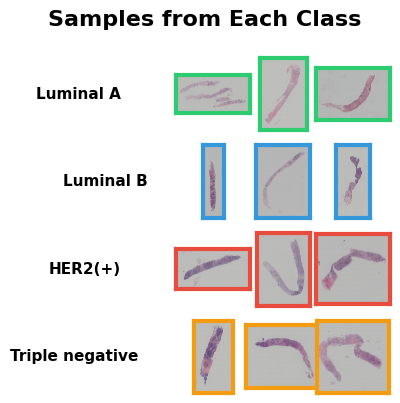

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(4, 4))
fig.suptitle('Samples from Each Class', fontsize=16, fontweight='bold', y=0.995)

class_names = ['Luminal A', 'Luminal B', 'HER2(+)', 'Triple negative']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for class_idx, class_name in enumerate(class_names):
    class_samples = train_labels[train_labels['label'] == class_name]['sample_index'].tolist()
    selected_samples = random.sample(class_samples, min(3, len(class_samples)))
    
    for col_idx, sample_idx in enumerate(selected_samples):
        ax = axes[class_idx, col_idx]
        
        img_path = os.path.join(train_img_dir, str(sample_idx))
        
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.values():
            spine.set_edgecolor(colors[class_idx])
            spine.set_linewidth(3)
        
        if col_idx == 0:
            ax.set_ylabel(class_name, fontsize=11, fontweight='bold', 
                         rotation=0, ha='right', va='center', labelpad=40)

plt.tight_layout()
plt.savefig('sample_images_grid.png', bbox_inches='tight', dpi=300)
plt.show()

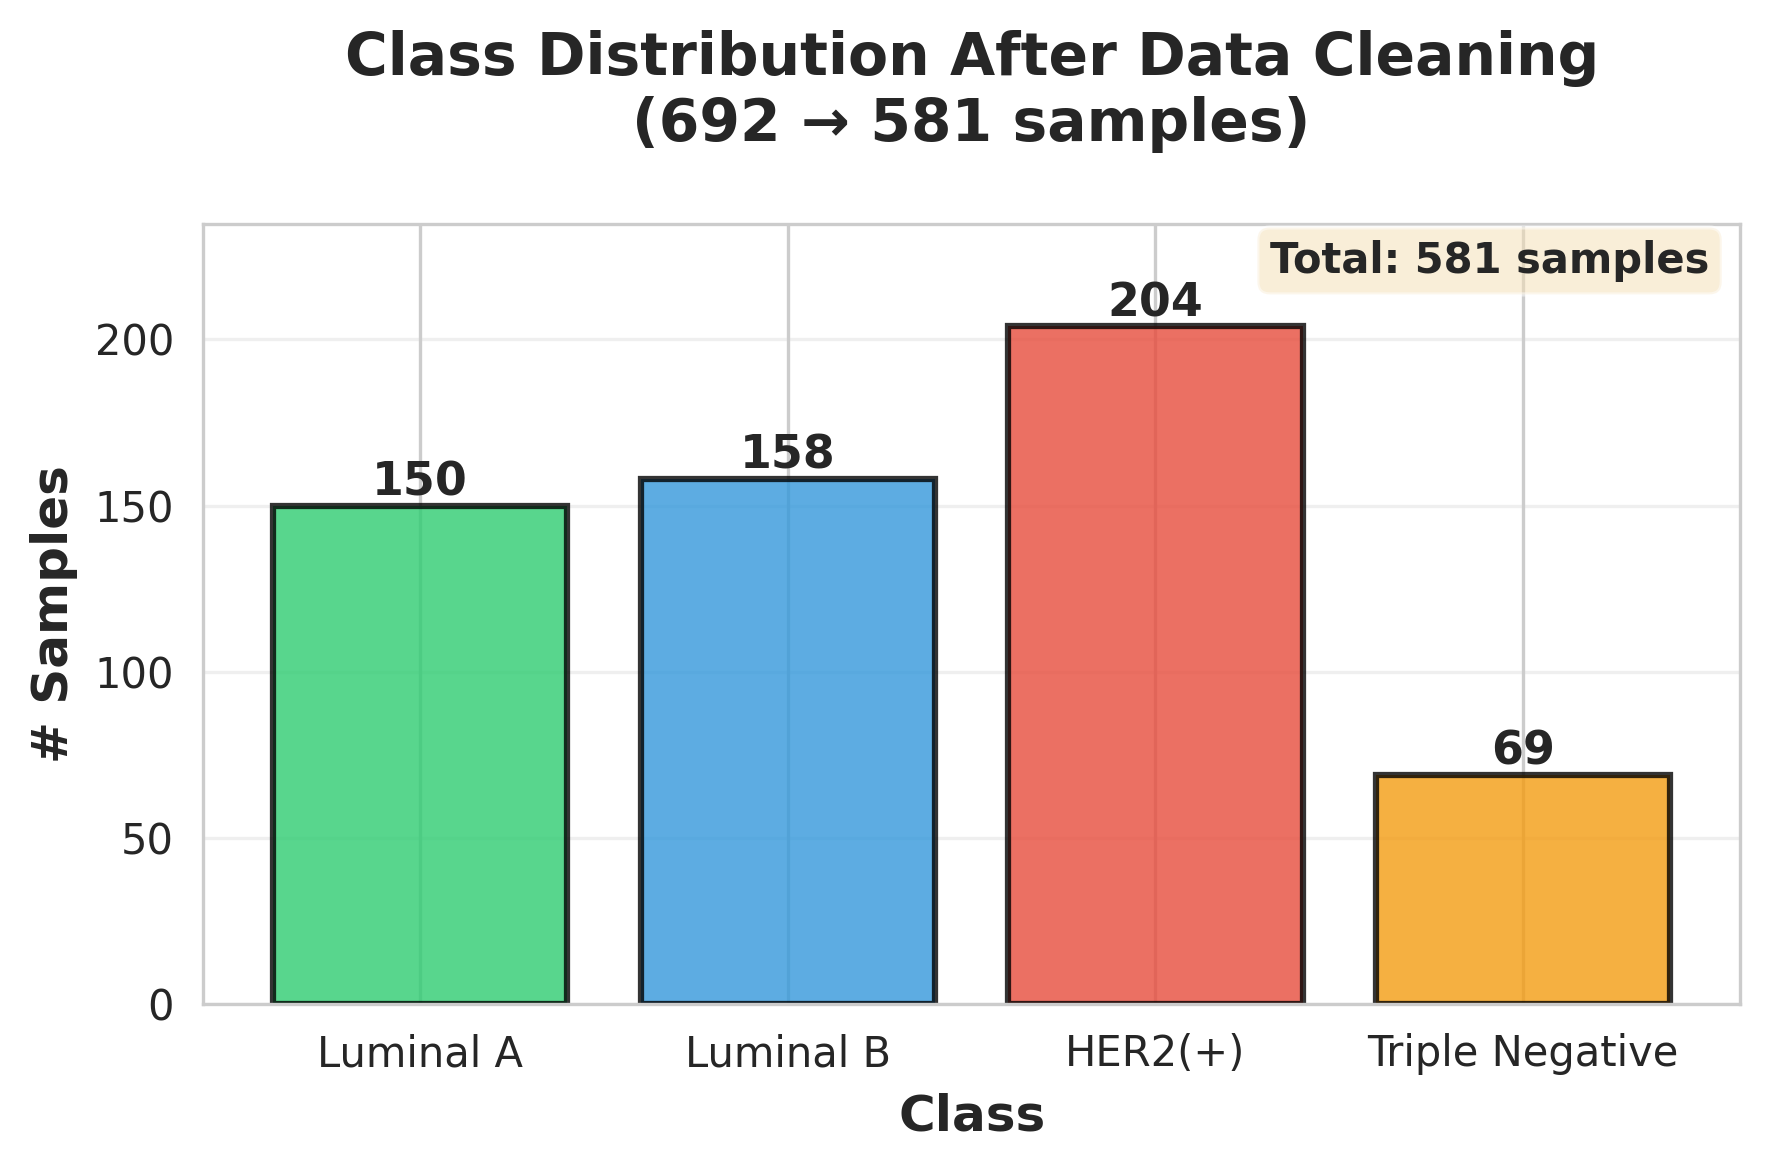

In [7]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

original_counts = train_labels['label'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
class_names = ['Luminal A', 'Luminal B', 'HER2(+)', 'Triple Negative']

bars = ax.bar(range(len(original_counts)), original_counts.values, 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for i, (bar, count) in enumerate(zip(bars, original_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('# Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution After Data Cleaning\n(692 → 581 samples)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(original_counts.values) * 1.15)

total = sum(original_counts.values)
ax.text(0.98, 0.98, f'Total: {total} samples', 
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', bbox_inches='tight')
plt.show()

## Data Exploration

## Masks as Focus Filters

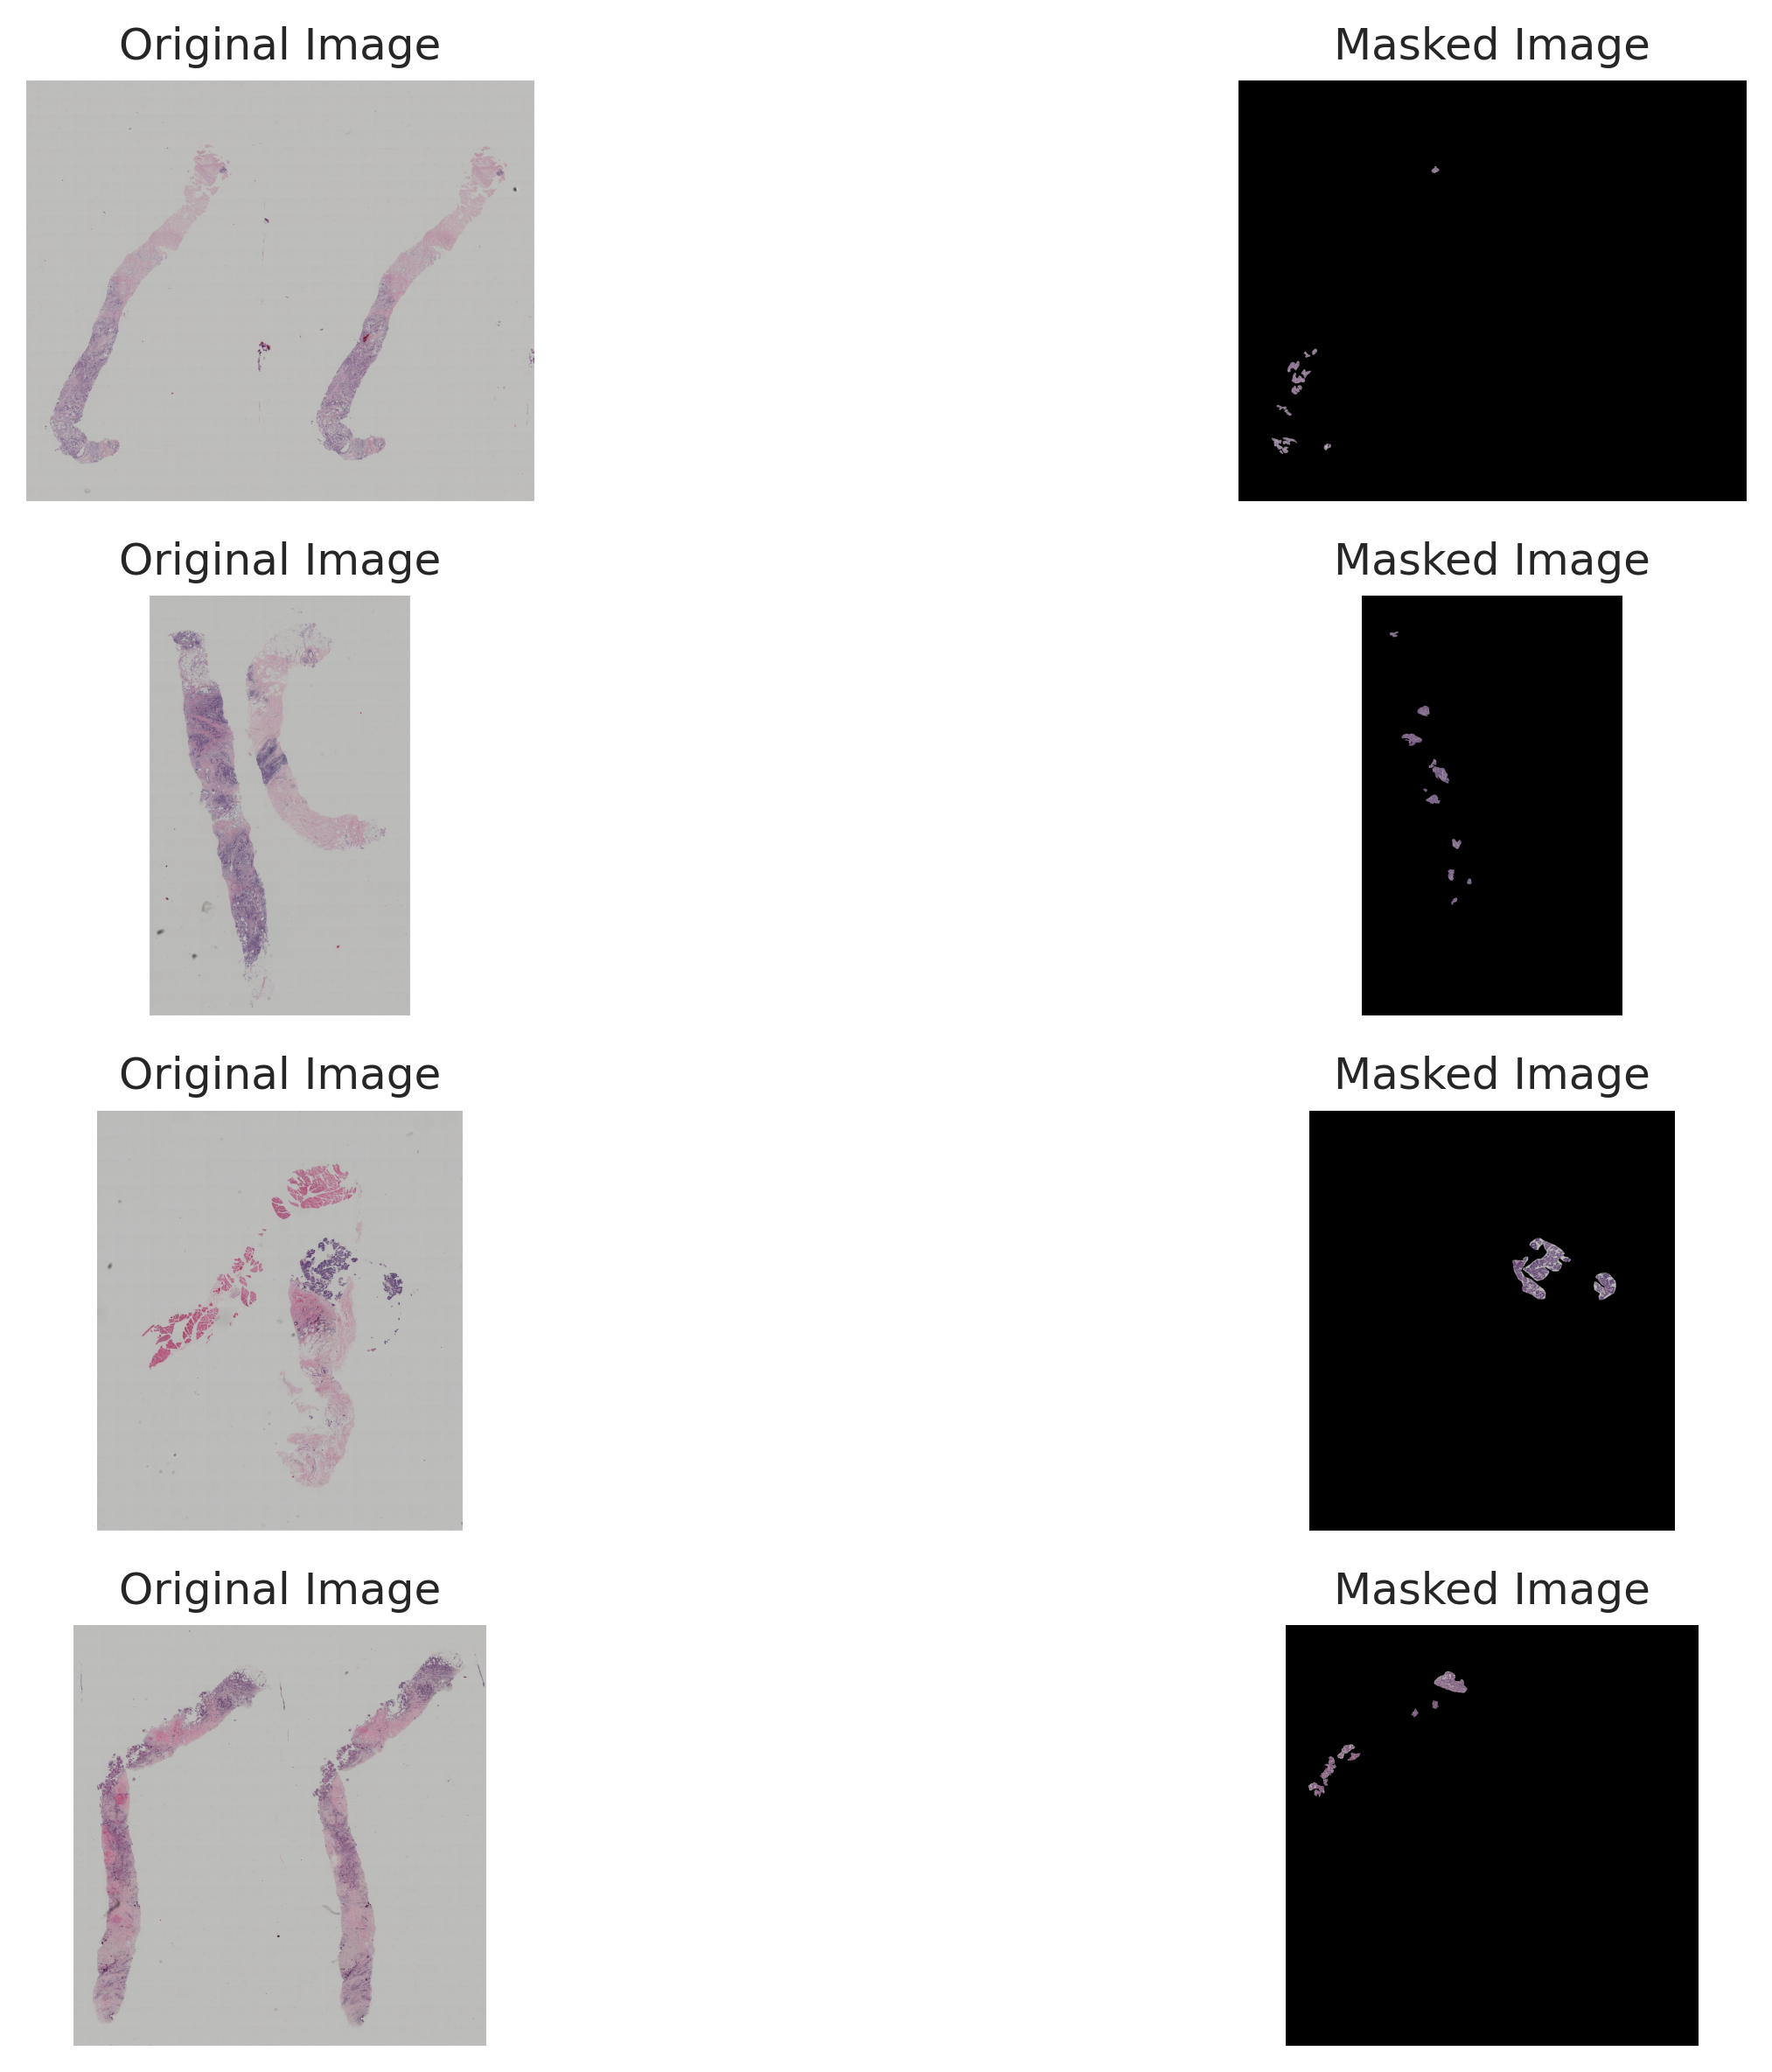

In [8]:
def apply_mask(image, mask):
    """Apply binary mask to image. Masked pixels are set to black."""
    img_np = np.array(image).astype(np.uint8)
    mask_np = np.array(mask).astype(np.uint8) / 255.0
    
    if img_np.ndim == 3:
        mask_np = np.expand_dims(mask_np, axis=-1)
    
    masked_img_np = (img_np * mask_np).astype(np.uint8)
    return Image.fromarray(masked_img_np)

samples = sorted(os.listdir(train_img_dir))[:4]
fig, axes = plt.subplots(len(samples), 2, figsize=(12, 2 * len(samples)))

for i, img_name in enumerate(samples):
    img_path = os.path.join(train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    masked_image = apply_mask(image, mask)

    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masked_image)
    axes[i, 1].set_title("Masked Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Save masked images to a new directory
masked_train_img_dir = PATH_PREFIX + 'data/train_img_masked/'
os.makedirs(masked_train_img_dir, exist_ok=True)
masked_test_img_dir = PATH_PREFIX + 'data/test_img_masked/'
os.makedirs(masked_test_img_dir, exist_ok=True)

# Apply masking to all training images and save
train_img_files = sorted(os.listdir(train_img_dir))

for img_name in tqdm(train_img_files, desc="Processing training images"):
    img_path = os.path.join(train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    masked_image = apply_mask(image, mask)
    masked_image.save(os.path.join(masked_train_img_dir, img_name))
print("Masked training images saved.")

# Apply masking to all test images and save
test_img_files = sorted(os.listdir(test_img_dir))
for img_name in tqdm(test_img_files, desc="Processing test images"):
    img_path = os.path.join(test_img_dir, img_name)
    mask_path = os.path.join(test_mask_dir, img_name.replace("img_", "mask_"))
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    masked_image = apply_mask(image, mask)
    masked_image.save(os.path.join(masked_test_img_dir, img_name))

print("Masked test images saved.")

Processing training images: 100%|██████████| 581/581 [01:08<00:00,  8.54it/s]


Masked training images saved.


Processing test images: 100%|██████████| 477/477 [00:57<00:00,  8.31it/s]

Masked test images saved.


## Augmentation

In [10]:
# Analyze class distribution after removal
class_distribution = train_labels['label'].value_counts().sort_index()

# Class with the most samples (majority)
max_class = class_distribution.max()
max_class_name = class_distribution.idxmax()
print(f"\nClass with the most samples (Majority): {max_class_name} ({max_class} samples)")

# Class with the fewest samples (minority)
min_class = class_distribution.min()
min_class_name = class_distribution.idxmin()
print(f"Class with the fewest samples (Minority): {min_class_name} ({min_class} samples)")

# Imbalance ratio
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (Max/Min): {imbalance_ratio:.2f}x")

# Augmentation strategy
print("\n" + "="*60)
print("Augmentation Strategy:")
print("="*60)
print("\nAugmentations to apply:")
print("  1. Horizontal Flip (p=0.5)")
print("  2. Vertical Flip (p=0.5)")
print("  3. Random Translation (0.2, 0.2)")
print("  4. Random Zoom/Scale (0.8, 1.2)")

# Target number of samples for each class
target_samples = 250

print(f"\nTarget: {target_samples} samples for EACH class")

augmentation_strategy_balanced = {}
total_to_generate = 0

for class_name in class_distribution.index:
    n_samples = class_distribution[class_name]
    n_needed = target_samples - n_samples
    n_augmentations = max(0, n_needed)  # We cannot have negative augmentations
    
    augmentation_strategy_balanced[class_name] = {
        'original': n_samples,
        'target': target_samples,
        'augment_count': n_augmentations,
        'ratio_multiplier': n_augmentations / n_samples if n_samples > 0 else 0
    }
    
    total_to_generate += n_augmentations

# Projection of the dataset after augmentation
print("\n" + "="*80)
print("Data after balanced augmentation:")
print("="*80)
print(f"{'Class':<20} {'Original':<15} {'New Augment':<15} {'Augmentations per image':<25} {'Total':<15}")
print("-" * 80)

total_original = 0
total_augmented = 0
for class_name in class_distribution.index:
    n_original = class_distribution[class_name]
    n_aug = augmentation_strategy_balanced[class_name]['augment_count']
    n_total = n_original + n_aug
    
    total_original += n_original
    total_augmented += n_total
    
    print(f"{class_name:<20} {n_original:<15} {n_aug:<15} {augmentation_strategy_balanced[class_name]['ratio_multiplier']:<25.2f} {n_total:<15}")

print("-" * 80)
print(f"{'TOTAL':<20} {total_original:<15} {total_to_generate:<15} {np.mean([augmentation_strategy_balanced[class_name]['ratio_multiplier'] for class_name in class_distribution.index]):<25.2f} {total_augmented:<15}")


Class with the most samples (Majority): Luminal B (204 samples)
Class with the fewest samples (Minority): Triple negative (69 samples)

Imbalance ratio (Max/Min): 2.96x

Augmentation Strategy:

Augmentations to apply:
  1. Horizontal Flip (p=0.5)
  2. Vertical Flip (p=0.5)
  3. Random Translation (0.2, 0.2)
  4. Random Zoom/Scale (0.8, 1.2)

Target: 250 samples for EACH class

Data after balanced augmentation:
Class                Original        New Augment     Augmentations per image   Total          
--------------------------------------------------------------------------------
HER2(+)              150             100             0.67                      250            
Luminal A            158             92              0.58                      250            
Luminal B            204             46              0.23                      250            
Triple negative      69              181             2.62                      250            
-----------------------------

In [11]:
# Create folder for augmented data if it doesn't exist
augmented_dir = PATH_PREFIX + f'data/train_data_augmented/'
train_dir = PATH_PREFIX + 'data/train_img_cropped/'
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
    print(f"Created directory: {augmented_dir}")
else:
    existing_files = len(os.listdir(augmented_dir))
    print(f"Directory already exists: {augmented_dir}")
    print(f"Found {existing_files} existing augmented files")

# Define augmentations for each class
# Using expand=True in RandomRotation to preserve aspect ratio and prevent cropping
augmentation_transforms = {
    'flip': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180, expand=True, fill=0)  # expand=True prevents cropping, fill=0 for black padding
    ]),
}

print("\nStarting augmentation")

# Loop through each class and generate augmentations
total_augmented = 0
augmented_rows = []

for class_name in sorted(augmentation_strategy_balanced.keys()):
    info = augmentation_strategy_balanced[class_name]
    n_augment = info['augment_count']
    
    if n_augment == 0:
        print(f"\n{class_name}: No augmentation needed (already at target)")
        continue
    
    # Get original images of this class
    class_samples = train_labels[train_labels['label'] == class_name]['sample_index'].tolist()
    n_original = len(class_samples)
    
    # Calculate how many augmentations per original image
    aug_per_img = n_augment / n_original
    
    # For each original image
    aug_count = 0
    for img_idx, img_name in enumerate(tqdm(class_samples, desc=f"Augmenting {class_name}")):        
        img_path = os.path.join(masked_train_img_dir, img_name)
        
        if not os.path.exists(img_path):
            print(f"  File not found: {img_name}")
            continue
        
        # Load the original image/mask
        img = Image.open(img_path).convert('RGB')
        img_pil = img.copy()
        
        # Generate augmentations for this image
        n_to_generate = int(np.ceil(aug_per_img)) if img_idx < n_augment % n_original else int(np.floor(aug_per_img))
        
        for aug_num in range(n_to_generate):
            if aug_count <= n_augment:
                base_name = img_name.replace('.png', '')

                # Choose an augmentation type cyclically
                aug_types = list(augmentation_transforms.keys())
                aug_type = aug_types[aug_count % len(aug_types)]
                transform = augmentation_transforms[aug_type]
                img_augmented = transform(img_pil)
                augmented_img_name = f"{base_name}_aug_{aug_num}_{aug_type}.png"
                
                # Save augmented image
                augmented_img_path = os.path.join(augmented_dir, augmented_img_name)
                img_augmented.save(augmented_img_path)
                
                # Add new row for augmented image
                augmented_rows.append({'sample_index': augmented_img_name, 'label': class_name})
                
            aug_count += 1
    
    total_augmented += aug_count
    print(f"  {class_name}: Completed. {aug_count} augmentations generated")

# Update train_labels with augmented files
if augmented_rows:
    train_labels = pd.concat([train_labels, pd.DataFrame(augmented_rows)], ignore_index=True)
    print(f"train_labels updated: {len(train_labels)} rows (including augmentations)")

print(f"Total augmented images generated: {total_augmented}")
print(f"Save directory: {augmented_dir}")

# Verify file count
augmented_files = os.listdir(augmented_dir)
print(f"\nFiles in augmented folder: {len(augmented_files)}")

Created directory: ./data/train_data_augmented/

Starting augmentation


Augmenting HER2(+): 100%|██████████| 150/150 [00:10<00:00, 14.38it/s]


  HER2(+): Completed. 100 augmentations generated


Augmenting Luminal A: 100%|██████████| 158/158 [00:09<00:00, 16.77it/s]


  Luminal A: Completed. 92 augmentations generated


Augmenting Luminal B: 100%|██████████| 204/204 [00:07<00:00, 28.32it/s]


  Luminal B: Completed. 46 augmentations generated


Augmenting Triple negative: 100%|██████████| 69/69 [00:15<00:00,  4.52it/s]

  Triple negative: Completed. 181 augmentations generated
train_labels updated: 1000 rows (including augmentations)
Total augmented images generated: 419
Save directory: ./data/train_data_augmented/

Files in augmented folder: 419


## Crop Masked Images

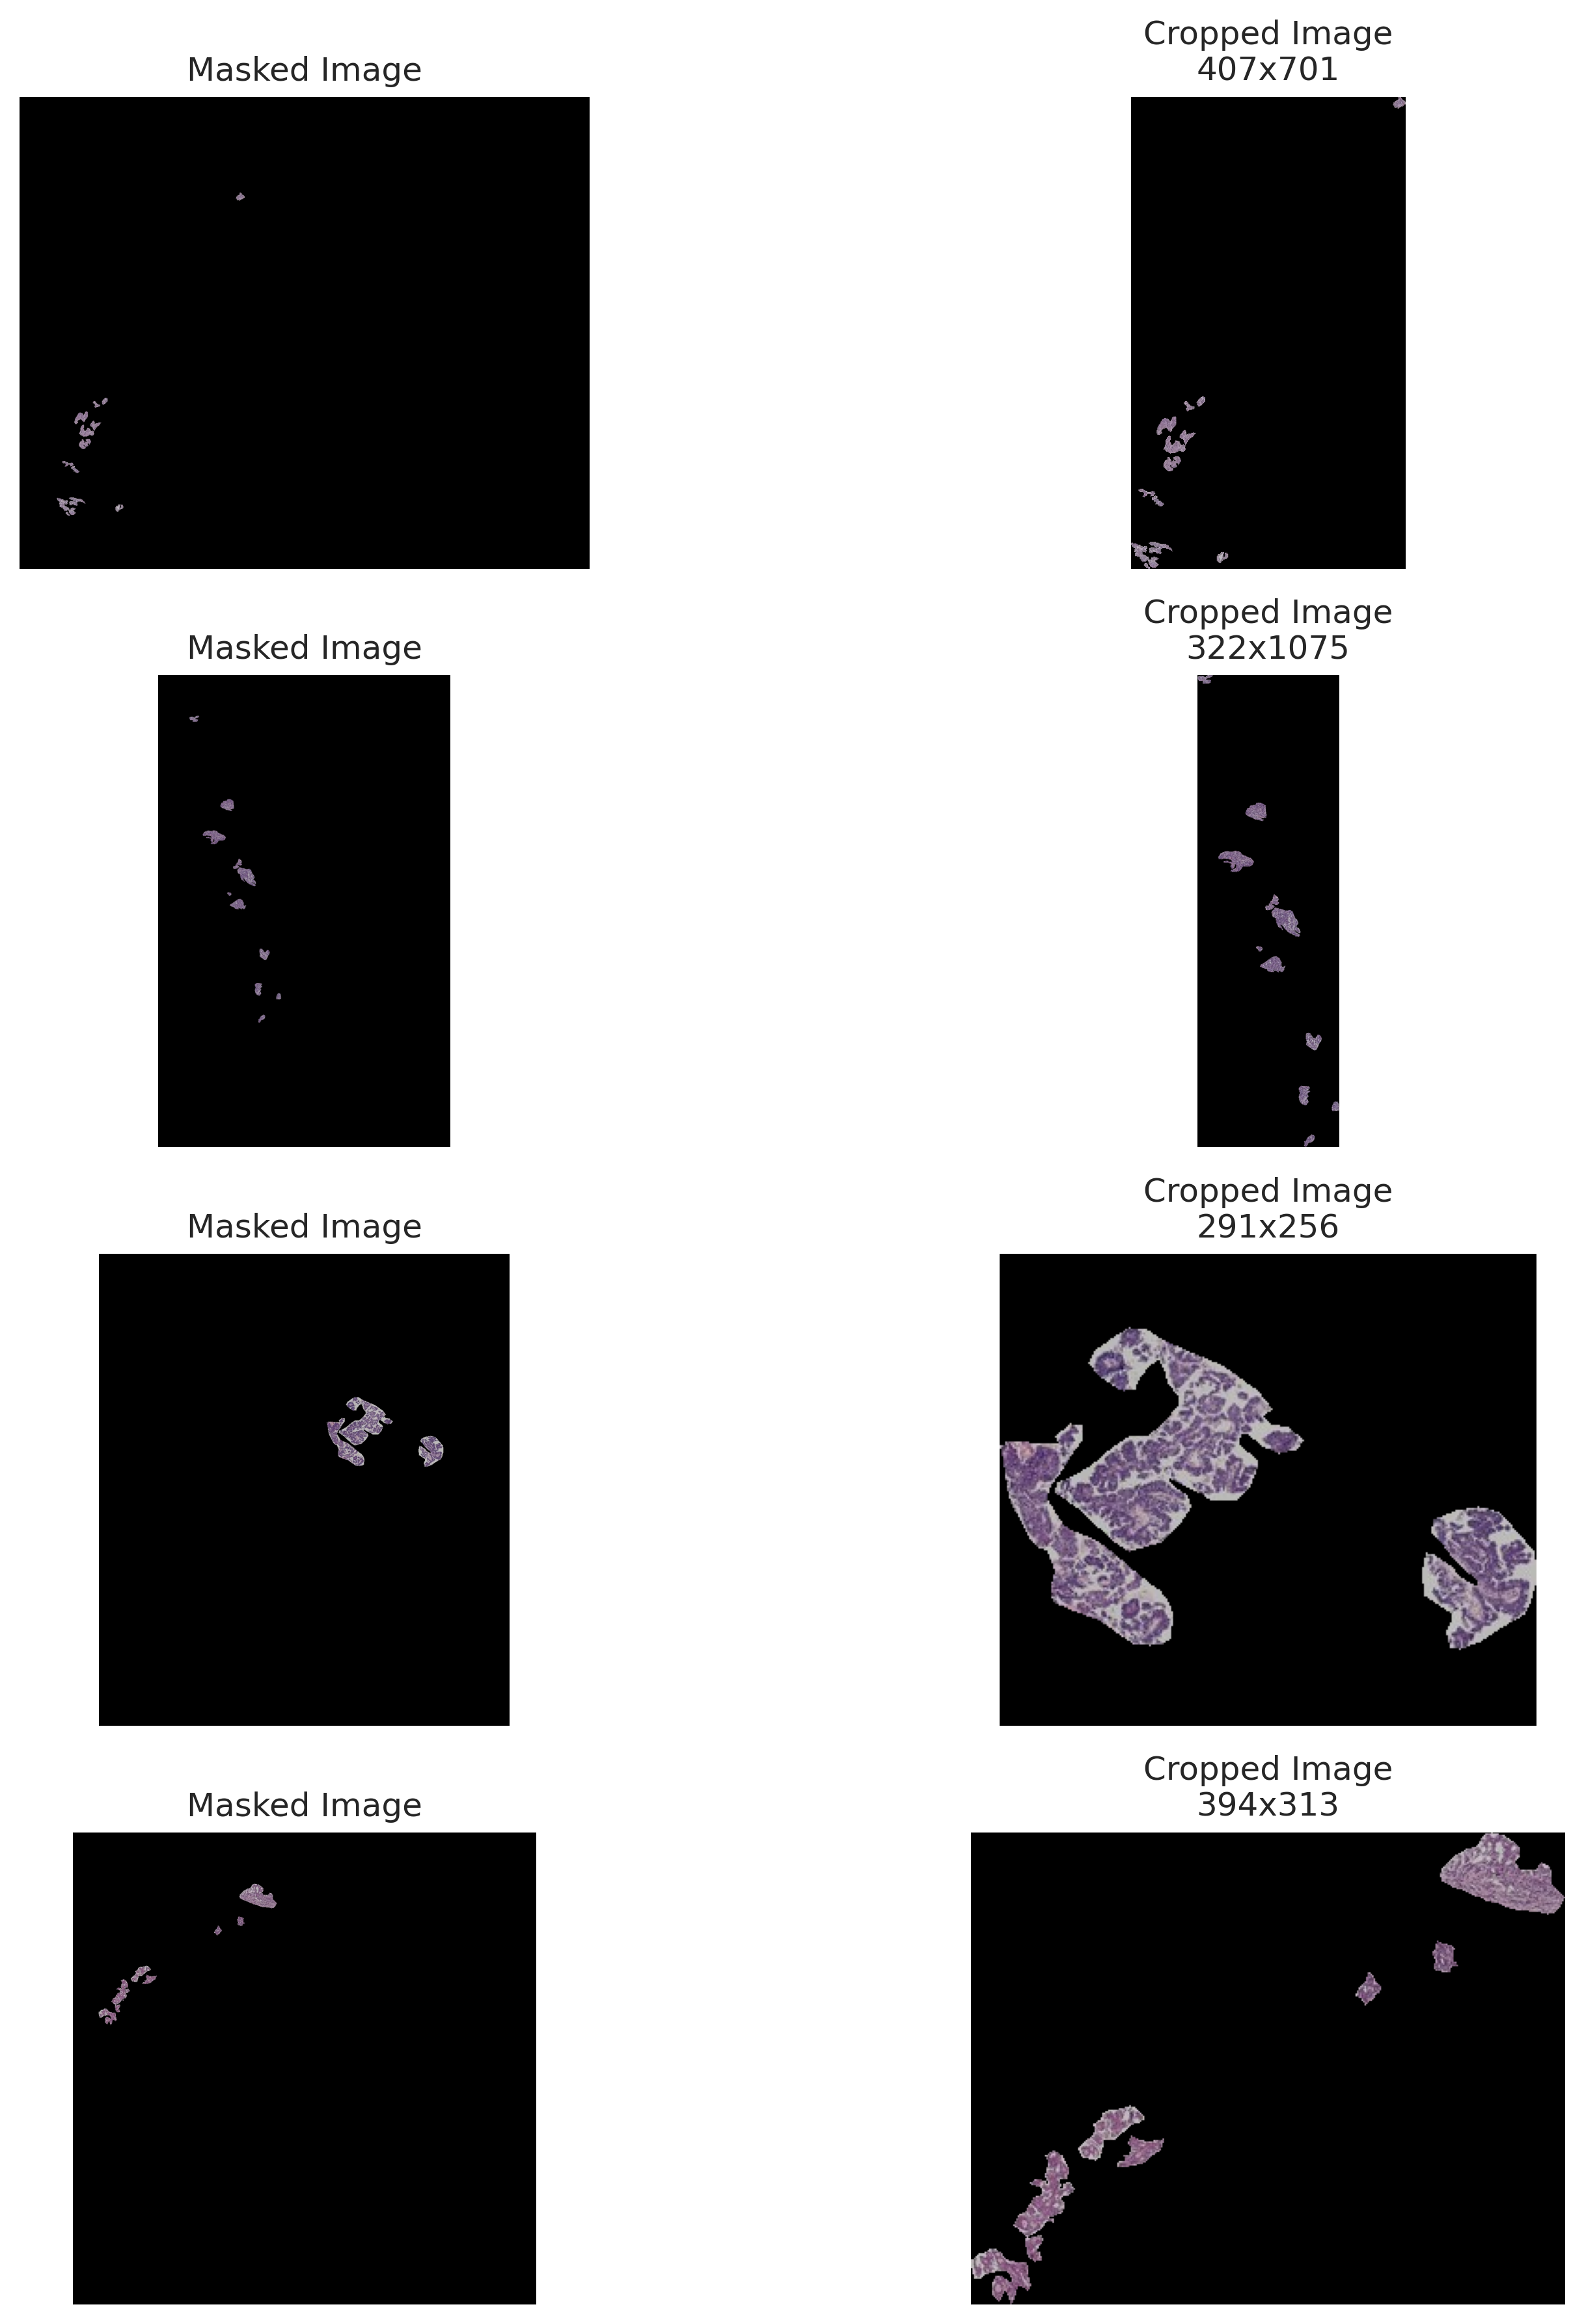

In [12]:
MIN_IMG_SIZE = (256, 256)

def crop_to_mask(image, min_size=MIN_IMG_SIZE):
    """Crop image to bounding box of non-zero pixels and pad if needed."""
    img_np = np.array(image).astype(np.uint8)
    non_zero_mask = np.sum(img_np, axis=2) > 0
    coords = np.column_stack(np.where(non_zero_mask))
    
    if coords.size == 0:
        return image
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0) + 1
    cropped = image.crop((x_min, y_min, x_max, y_max))
    
    width, height = cropped.size
    min_width, min_height = min_size
    
    if width < min_width or height < min_height:
        pad_width = max(0, min_width - width)
        pad_height = max(0, min_height - height)
        padded = Image.new('RGB', (max(width, min_width), max(height, min_height)), (0, 0, 0))
        padded.paste(cropped, (pad_width // 2, pad_height // 2))
        return padded
    
    return cropped

samples = sorted(os.listdir(masked_train_img_dir))[:4]
fig, axes = plt.subplots(len(samples), 2, figsize=(12, 3 * len(samples)))

for i, img_name in enumerate(samples):
    img_path = os.path.join(masked_train_img_dir, img_name)
    mask_path = os.path.join(train_mask_dir, img_name.replace("img_", "mask_"))

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    masked_image = apply_mask(image, mask)
    cropped_image = crop_to_mask(masked_image)

    axes[i, 0].imshow(masked_image)
    axes[i, 0].set_title("Masked Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cropped_image)
    axes[i, 1].set_title(f"Cropped Image\n{cropped_image.size[0]}x{cropped_image.size[1]}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Crop all images and save to new directories
# Define new directories for cropped images
cropped_train_img_dir = PATH_PREFIX + 'data/train_img_cropped/'
cropped_test_img_dir = PATH_PREFIX + 'data/test_img_cropped/'
os.makedirs(cropped_train_img_dir, exist_ok=True)
os.makedirs(cropped_test_img_dir, exist_ok=True)

# Process training images
for img_name in tqdm(os.listdir(masked_train_img_dir), desc="Processing training images"):
    img_path = os.path.join(masked_train_img_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_train_img_dir, img_name))
print("\nCropped training images saved.")
# Process test images
for img_name in tqdm(os.listdir(masked_test_img_dir), desc="Processing test images"):
    img_path = os.path.join(masked_test_img_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_test_img_dir, img_name))
print("\nCropped test images saved.")

# Crop also all augmented images
for img_name in tqdm(os.listdir(augmented_dir), desc="Processing augmented images"):
    img_path = os.path.join(augmented_dir, img_name)

    image = Image.open(img_path).convert("RGB")

    cropped_image = crop_to_mask(image)

    cropped_image.save(os.path.join(cropped_train_img_dir, img_name))
print("\nCropped augmented images saved.")

Processing training images: 100%|██████████| 581/581 [00:45<00:00, 12.89it/s]



Cropped training images saved.


Processing test images: 100%|██████████| 477/477 [00:39<00:00, 12.22it/s]



Cropped test images saved.


Processing augmented images: 100%|██████████| 419/419 [00:50<00:00,  8.26it/s]


Cropped augmented images saved.


# Dataloaders

## Blank Patch Filtering

Patches with zero or near-zero information content (black backgrounds, empty borders) are filtered using variance-based thresholding:
- Variance threshold: 0.001
- Only patches with variance > threshold are included
- Applied during patch extraction for both training and test data

This reduces dataset size and improves training efficiency.

In [14]:
imagenet_norm = transforms.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

# ===== PATCH-BASED PROCESSING SETTINGS =====
# Instead of resizing images to 224x224 (which loses detail),
# we extract patches at full resolution and process them separately
PATCH_SIZE = 256  # Size of each patch (256x256)
PATCH_STRIDE = 100
# ==========================================

# For backward compatibility when not using patches
IMG_SIZE = (PATCH_SIZE, PATCH_SIZE)

# Create DataLoaders
# Larger batch size for multi-GPU: DataParallel splits batch across GPUs
# With 2 GPUs: effective batch per GPU = BATCH_SIZE / 2
BATCH_SIZE = 128  # 64 per GPU with DataParallel

# ===== GPU OPTIMIZATION SETTINGS =====
# Kaggle T4 x2 optimization: maximize data loading throughput
# Each T4 GPU can handle 4 workers efficiently
import torch
if torch.cuda.is_available():
    NUM_WORKERS = 2 * torch.cuda.device_count()  # 2 workers per GPU = 4 total for T4 x2
    PIN_MEMORY = True  # CRITICAL: Enables async CPU-to-GPU transfer while GPU computes
    PERSISTENT_WORKERS = True  # Keeps workers alive between epochs (faster)
    print(f"GPU detected: {torch.cuda.device_count()} GPU(s) - using {NUM_WORKERS} workers")
else:
    # CPU-only environment
    NUM_WORKERS = 0
    PIN_MEMORY = False
    PERSISTENT_WORKERS = False
# ======================================

# Load original + augmented images into tensors
print("Loading cropped images from disk")
print(f"Cropped directory: {cropped_train_img_dir}")

# Check if augmented directory exists and validate files
if not os.path.exists(augmented_dir):
    print(f"\nWARNING: Augmented directory does not exist!")
    print(f"Expected: {augmented_dir}")
    print(f"No augmented data will be loaded. Only original images will be used.")
    augmented_files = []
else:
    # Create list of augmented images
    augmented_files = os.listdir(augmented_dir)
    print(f"Augmented images found: {len(augmented_files)}")

# Create new dataframe with all images (original + augmented)
train_labels_augmented = train_labels.copy()

# Add augmented images
augmented_rows = []
for aug_img_name in augmented_files:
    # Extract original file name (works for both img_ and mask_ prefixes)
    # Format: {prefix}_{number}_aug_{aug_num}_{aug_type}.png
    base_name = aug_img_name.split('_aug_')[0] + '.png'
    
    original_row = train_labels[train_labels['sample_index'] == base_name]
    if not original_row.empty:
        class_label = original_row.iloc[0]['label']
        augmented_rows.append({'sample_index': aug_img_name, 'label': class_label})

augmented_df = pd.DataFrame(augmented_rows)
train_labels_augmented = pd.concat([train_labels_augmented, augmented_df], ignore_index=True)

print(f"\nOriginal dataset: {len(train_labels)} samples")
print(f"Augmented dataset: {len(train_labels_augmented)} samples")
print(f"\nDistribution in augmented dataset:")
print(train_labels_augmented['label'].value_counts().sort_index())

print("Patch pre-extraction to disk")

# Directory to save pre-extracted patches
patches_dir = os.path.join(PATH_PREFIX, "data", "patches_cache")
os.makedirs(patches_dir, exist_ok=True)

# Metadata file to track all batch files
metadata_file = os.path.join(patches_dir, f"metadata_ps{PATCH_SIZE}_stride{PATCH_STRIDE}.json")

if os.path.exists(metadata_file):
    print(f"Found pre-extracted patches. Loading metadata from {metadata_file}...")
    
    import json
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"Found {metadata['num_batches']} batch files with {metadata['total_patches']} total patches")
    print(f"Found {metadata['num_batches']} batch files with {metadata['total_patches']} total patches")
    
else:
    print("No pre-extracted patches found. Extracting now...")
    print("Strategy: Save each batch to separate file to minimize memory usage.")
    
    # Helper function to extract patches from a single image
    def extract_patches_from_image(img_path, patch_size, stride, min_variance_threshold=0.001):
        """
        Extract all patches from a single image, filtering out blank patches.
        
        Args:
            img_path: Path to the image file
            patch_size: Size of each patch
            stride: Stride for patch extraction
            min_variance_threshold: Minimum variance to consider patch non-blank (default: 0.001)
        
        Returns:
            List of patch tensors (excluding blank patches)
        """
        img = Image.open(img_path).convert('RGB')
        
        img_array = np.array(img, dtype=np.float32)
        h, w, c = img_array.shape
        patches = []
        
        if h < patch_size or w < patch_size:
            pad_h = max(0, patch_size - h)
            pad_w = max(0, patch_size - w)
            img_array = np.pad(img_array, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            patch = img_array[:patch_size, :patch_size, :]
            
            # Check if patch is not blank
            patch_normalized = patch / 255.0
            if np.var(patch_normalized) > min_variance_threshold:
                patch_tensor = torch.from_numpy(patch.transpose(2, 0, 1) / 255.0).float()
                patches.append(patch_tensor)
        else:
            n_patches_h = max(1, (h - patch_size) // stride + 1)
            n_patches_w = max(1, (w - patch_size) // stride + 1)
            
            for row_idx in range(n_patches_h):
                for col_idx in range(n_patches_w):
                    start_h = min(row_idx * stride, h - patch_size)
                    start_w = min(col_idx * stride, w - patch_size)
                    patch = img_array[start_h:start_h+patch_size, start_w:start_w+patch_size, :]
                    
                    # Check if patch is not blank (has sufficient variance)
                    patch_normalized = patch / 255.0
                    if np.var(patch_normalized) > min_variance_threshold:
                        patch_tensor = torch.from_numpy(patch.transpose(2, 0, 1) / 255.0).float()
                        patches.append(patch_tensor)
        
        return patches
    
    label_map = {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}
    IMAGES_PER_BATCH = 50  # Process 50 images at a time (stride=256 = 4x fewer patches)
    
    print(f"\nExtracting and saving patches in batches of {IMAGES_PER_BATCH} images...")
    
    batch_patches = []
    batch_labels = []
    batch_num = 0
    total_patches = 0
    batch_files = []
    
    for idx, row in train_labels_augmented.iterrows():
        if idx % 10 == 0:
            print(f"  Progress: {idx}/{len(train_labels_augmented)} images...")
        
        img_name = row['sample_index']
        label = label_map[row['label']]
        
        img_path = os.path.join(cropped_train_img_dir, img_name)
        
        if os.path.exists(img_path):
            patches = extract_patches_from_image(img_path, PATCH_SIZE, PATCH_STRIDE)
            batch_patches.extend(patches)
            batch_labels.extend([label] * len(patches))
        
        # Save batch to disk when full (DON'T accumulate in memory!)
        if (idx + 1) % IMAGES_PER_BATCH == 0 or idx == len(train_labels_augmented) - 1:
            if len(batch_patches) > 0:
                batch_tensor = torch.stack(batch_patches)
                batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long)
                
                # Save this batch to its own file
                batch_file = os.path.join(patches_dir, f"batch_{batch_num:03d}.pt")
                torch.save({'patches': batch_tensor, 'labels': batch_labels_tensor}, batch_file)
                
                batch_files.append(batch_file)
                total_patches += len(batch_patches)
                print(f"    ✓ Saved batch {batch_num}: {len(batch_patches)} patches → {batch_file}")
                
                # CRITICAL: Clear memory immediately!
                batch_patches = []
                batch_labels = []
                batch_num += 1
    
    # Save metadata
    import json
    metadata = {
        'num_batches': batch_num,
        'total_patches': total_patches,
        'batch_files': batch_files,
        'patch_size': PATCH_SIZE,
        'stride': PATCH_STRIDE
    }
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("\nExtraction complete")
    print(f"Saved {batch_num} batch files with {total_patches} total patches")
    print(f"Metadata saved to: {metadata_file}")

# Load metadata for dataset creation
import json
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(f"\n{'='*80}")
print("Creating multi-file dataset...")
print(f"Total patches: {metadata['total_patches']}")

# Custom Dataset that loads from multiple batch files
class MultiFilePatchDataset(Dataset):
    """Dataset that loads patches from multiple batch files with caching"""
    
    def __init__(self, metadata, use_pretrained: bool = False, transform=None):
        self.batch_files = metadata['batch_files']
        self.total_patches = int(metadata['total_patches'])

        self.use_pretrained = bool(use_pretrained)
        self.transform = transform  # opzionale: callable(x)->x

        # Cache per batch (key: batch_idx, value: batch_data)
        self._cache = {}

        # Indici per mappare idx globale -> (batch_idx, local_idx)
        self.batch_sizes = []
        self.cumulative_sizes = [0]

        print(f"Loading batch data from {len(self.batch_files)} files...")
        for batch_idx, batch_file in enumerate(self.batch_files):
            batch_data = torch.load(batch_file, map_location="cpu")
            # attesi: batch_data['patches'], batch_data['labels']
            n = batch_data['labels'].shape[0]

            self._cache[batch_idx] = batch_data
            self.batch_sizes.append(n)
            self.cumulative_sizes.append(self.cumulative_sizes[-1] + n)

        # In caso il metadata non coincida, rendi coerente con quanto caricato
        self.total_patches = self.cumulative_sizes[-1]
    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        batch_idx = np.searchsorted(self.cumulative_sizes[1:], idx, side='right')
        local_idx = idx - self.cumulative_sizes[batch_idx]

        batch_data = self._cache[batch_idx]

        x = batch_data['patches'][local_idx]   # (3,H,W) in [0,1]
        y = batch_data['labels'][local_idx]

        if self.use_pretrained:
            x = self.transform(x) if self.transform is not None else imagenet_norm(x)

        return x, y


# Load metadata for dataset creation
import json
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Create dataset
full_dataset = MultiFilePatchDataset(metadata, transform=imagenet_norm) 


# ===== CREATE TRAIN/VAL SPLIT =====
print("Creating train/val split...")

# Create indices for train/val split
# Need to load all labels to stratify properly
print("Loading all labels for stratified split...")
all_labels_list = []
for batch_file in metadata['batch_files']:
    batch_data = torch.load(batch_file)
    all_labels_list.extend(batch_data['labels'].tolist())

all_labels_array = np.array(all_labels_list)

# Split indices (not data!)
train_indices, val_indices = train_test_split(
    np.arange(len(all_labels_array)), test_size=0.2, random_state=42, 
    stratify=all_labels_array
)

print(f"Train patches: {len(train_indices)}")
print(f"Val patches: {len(val_indices)}")

# Create subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

label_map = {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}

# Create DataLoaders with GPU optimizations
train_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
val_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    train_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS
    val_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

train_loader = DataLoader(train_dataset, **train_loader_kwargs)
val_loader = DataLoader(val_dataset, **val_loader_kwargs)

print(f"\nOptimization: {NUM_WORKERS} workers, pin_memory={PIN_MEMORY}, persistent_workers={PERSISTENT_WORKERS}")
print(f"\nCreated DataLoaders:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

GPU detected: 2 GPU(s) - using 4 workers
Loading cropped images from disk
Cropped directory: ./data/train_img_cropped/
Augmented images found: 419

Original dataset: 1000 samples
Augmented dataset: 1419 samples

Distribution in augmented dataset:
label
HER2(+)            350
Luminal A          342
Luminal B          296
Triple negative    431
Name: count, dtype: int64
Patch pre-extraction to disk
No pre-extracted patches found. Extracting now...
Strategy: Save each batch to separate file to minimize memory usage.

Extracting and saving patches in batches of 50 images...
  Progress: 0/1419 images...
  Progress: 10/1419 images...
  Progress: 20/1419 images...
  Progress: 30/1419 images...
  Progress: 40/1419 images...
    ✓ Saved batch 0: 486 patches → ./data/patches_cache/batch_000.pt
  Progress: 50/1419 images...
  Progress: 60/1419 images...
  Progress: 70/1419 images...
  Progress: 80/1419 images...
  Progress: 90/1419 images...
    ✓ Saved batch 1: 504 patches → ./data/patches_cache

In [15]:
imagenet_norm = transforms.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

# Memory-efficient test dataset
class TestPatchDataset(Dataset):
    """Memory-efficient test dataset that extracts patches on-the-fly"""
    
    def __init__(self, data_dir, patch_size=PATCH_SIZE, stride=PATCH_STRIDE,
                 min_variance_threshold=0.001, transform=None):
        self.data_dir = data_dir
        self.patch_size = patch_size
        self.stride = stride
        self.min_variance_threshold = min_variance_threshold

        self.transform = transform  # optional: callable(x)->x

        self.use_patches = bool(self.patch_size) and bool(self.stride)

        # Get image files
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.startswith('img_')])

        # Pre-compute patch counts and mapping (se uso patches)
        if self.use_patches:
            self.patch_counts = []
            self.cumulative_patches = [0]
            self.patch_to_image = []

            print(f"Computing patch counts for {len(self.image_files)} test images (filtering blank patches)...")
            for i, img_name in enumerate(self.image_files):
                img_path = os.path.join(self.data_dir, img_name)
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img, dtype=np.float32)
                h, w, _ = img_array.shape

                if h < self.patch_size or w < self.patch_size:
                    n_patches = 1
                else:
                    n_patches_h = max(1, (h - self.patch_size) // self.stride + 1)
                    n_patches_w = max(1, (w - self.patch_size) // self.stride + 1)

                    valid_patches = 0
                    for row_idx in range(n_patches_h):
                        for col_idx in range(n_patches_w):
                            start_h = min(row_idx * self.stride, h - self.patch_size)
                            start_w = min(col_idx * self.stride, w - self.patch_size)
                            patch = img_array[start_h:start_h+self.patch_size, start_w:start_w+self.patch_size, :]

                            if np.var(patch / 255.0) > self.min_variance_threshold:
                                valid_patches += 1

                    n_patches = max(1, valid_patches)

                self.patch_counts.append(n_patches)
                self.cumulative_patches.append(self.cumulative_patches[-1] + n_patches)
                for _ in range(n_patches):
                    self.patch_to_image.append(i)

            self.total_patches = self.cumulative_patches[-1]
            print(f"Total test patches (excluding blank): {self.total_patches}")
        else:
            self.total_patches = len(self.image_files)
            self.patch_to_image = list(range(len(self.image_files)))
    
    def __len__(self):
        return self.total_patches
    
    def _get_valid_patches_for_image(self, img_array, img_h, img_w):
        """Extract all valid (non-blank) patches from an image and return their positions"""
        valid_patches_info = []
        
        if img_h < self.patch_size or img_w < self.patch_size:
            # For small images, use padded single patch
            valid_patches_info.append((0, 0))  # placeholder position
        else:
            n_patches_h = max(1, (img_h - self.patch_size) // self.stride + 1)
            n_patches_w = max(1, (img_w - self.patch_size) // self.stride + 1)
            
            for row_idx in range(n_patches_h):
                for col_idx in range(n_patches_w):
                    start_h = min(row_idx * self.stride, img_h - self.patch_size)
                    start_w = min(col_idx * self.stride, img_w - self.patch_size)
                    patch = img_array[start_h:start_h+self.patch_size, start_w:start_w+self.patch_size, :]
                    
                    # Check if patch has sufficient variance
                    if np.var(patch / 255.0) > self.min_variance_threshold:
                        valid_patches_info.append((start_h, start_w))
            
            # Ensure at least one patch per image
            if len(valid_patches_info) == 0:
                valid_patches_info.append((0, 0))
        
        return valid_patches_info
    
    def __getitem__(self, idx):
        if self.use_patches:
            img_idx = np.searchsorted(self.cumulative_patches[1:], idx, side='right')
            patch_idx = idx - self.cumulative_patches[img_idx]
            img_name = self.image_files[img_idx]
        else:
            img_name = self.image_files[idx]

        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img, dtype=np.float32)

        if self.use_patches:
            h, w, _ = img_array.shape

            if h < self.patch_size or w < self.patch_size:
                pad_h = max(0, self.patch_size - h)
                pad_w = max(0, self.patch_size - w)
                img_array = np.pad(img_array, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
                final_img = img_array[:self.patch_size, :self.patch_size, :]
            else:
                valid_positions = self._get_valid_patches_for_image(img_array, h, w)
                # sicurezza: se per qualche motivo tornasse vuota
                if not valid_positions:
                    valid_positions = [(0, 0)]

                start_h, start_w = valid_positions[patch_idx % len(valid_positions)]
                final_img = img_array[start_h:start_h+self.patch_size, start_w:start_w+self.patch_size, :]
        else:
            img_pil = Image.fromarray(img_array.astype('uint8'))
            img_resized = img_pil.resize((self.patch_size, self.patch_size), Image.BILINEAR)
            final_img = np.array(img_resized)

        img_tensor = torch.from_numpy(final_img).permute(2, 0, 1).float() / 255.0

        # Use pre-trained ImageNet weights
        img_tensor = self.transform(img_tensor) if self.transform is not None else imagenet_norm(img_tensor)

        return img_tensor


# Load test data
print(f"\nLoading test data")
print(f"Using PATCH-BASED processing for test data")
    
test_dataset = TestPatchDataset(
    cropped_test_img_dir,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    transform=imagenet_norm
)

test_filenames = test_dataset.image_files
test_patch_to_image = test_dataset.patch_to_image

print(f"Test patches: {len(test_dataset)}")
print(f"Test image files: {len(test_filenames)}")

# Create DataLoader with GPU optimizations
test_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': False,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    test_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

test_loader = DataLoader(test_dataset, **test_loader_kwargs)

print(f"\nDataLoader created:")
print(f"Test batches: {len(test_loader)}")
print(f"Optimization: {NUM_WORKERS} workers, pin_memory={PIN_MEMORY}")


Loading test data
Using PATCH-BASED processing for test data
Computing patch counts for 477 test images (filtering blank patches)...
Total test patches (excluding blank): 4294
Test patches: 4294
Test image files: 477

DataLoader created:
Test batches: 34
Optimization: 4 workers, pin_memory=True


In [16]:
label_map = {class_names[i]: i for i in range(4)}
input_shape = (3, PATCH_SIZE, PATCH_SIZE) if PATCH_SIZE else (3, IMG_SIZE[0], IMG_SIZE[1])
num_classes = len(label_map)

# ===== MULTI-GPU SETUP =====
# Check for multiple GPUs and set up DataParallel
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device('cuda:0')
    print(f"Found {num_gpus} GPU(s) available:")
    for i in range(num_gpus):
        print(f" GPU {i}: {torch.cuda.get_device_name(i)}")
    if num_gpus > 1:
        print(f"Multi-GPU training enabled: Will use {num_gpus} GPUs with DataParallel")
    else:
        print(f"Single GPU training")
else:
    device = torch.device('cpu')
    num_gpus = 0
    print("No GPU available, using CPU")
# ===========================

Found 2 GPU(s) available:
 GPU 0: Tesla T4
 GPU 1: Tesla T4
Multi-GPU training enabled: Will use 2 GPUs with DataParallel


# Parameters

In [29]:
# Number of training epochs
LEARNING_RATE = 1e-4
EPOCHS = 500
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0.01         # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 500
Batch Size: 128
Learning Rate: 0.0001
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0.01


# Model Builder

In [18]:
# --- Swin Transformer ---
MODEL_NAME = "swin_t"
model = models.swin_t(weights=(Swin_T_Weights.IMAGENET1K_V1))
# Modify the model for our classification task
# Assuming model is already defined and loaded, e.g., a Swin Transformer or Vision Transformer
# Steps:

# 1) Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# 2) Replace head based on model type
if MODEL_NAME.startswith("swin") and hasattr(model, "head"):
    in_f = model.head.in_features
    model.head = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(in_f, num_classes)
    )

elif MODEL_NAME.startswith("vit") and hasattr(model, "heads"):
    # Vision Transformer
    in_f = model.heads.head.in_features
    model.heads = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(in_f, 256),
        nn.ReLU(),
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(256, num_classes)
    )

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print(f"DataParallel active on {torch.cuda.device_count()} GPUs")

model = model.to(device)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 216MB/s] 


DataParallel active on 2 GPUs


In [19]:
# Display model architecture summary
print("Model summary:")
summary(model, input_size=input_shape, device=str(device).split(':')[0])

# Count trainable vs frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("Parameter stats:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters (classifier only): {trainable_params:,}")
print(f"Frozen parameters (feature extractor): {frozen_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")
print("="*80)

Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 64, 64]           4,704
            Conv2d-2           [-1, 96, 64, 64]           4,704
           Permute-3           [-1, 64, 64, 96]               0
           Permute-4           [-1, 64, 64, 96]               0
         LayerNorm-5           [-1, 64, 64, 96]             192
         LayerNorm-6           [-1, 64, 64, 96]             192
         LayerNorm-7           [-1, 64, 64, 96]             192
         LayerNorm-8           [-1, 64, 64, 96]             192
ShiftedWindowAttention-9           [-1, 64, 64, 96]               0
  StochasticDepth-10           [-1, 64, 64, 96]               0
        LayerNorm-11           [-1, 64, 64, 96]             192
           Linear-12          [-1, 64, 64, 384]          37,248
ShiftedWindowAttention-13           [-1, 64, 64, 96]               0
  StochasticDep

In [20]:
# Define optimizer - ONLY train classifier parameters (feature extractor is frozen)
# Filter to get only parameters that require gradients (classifier layers)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("Optimizer configured to train only classifier layers")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay (L2): {L2_LAMBDA}")

Optimizer configured to train only classifier layers
Learning rate: 0.0001
Weight decay (L2): 0.01


# Training

In [21]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [22]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [23]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [24]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(),"models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history, best_metric

## Fitting

In [30]:
EXPERIMENT_NAME = f"pretrained_{MODEL_NAME}_transformer"

print(f"Training with {MODEL_NAME.upper()} pretrained - transfer learning")
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Frozen feature extractor + Trainable classifier")

model, history, best_f1 = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=10,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE
)

if best_f1 > best_performance:
    best_model = model
    best_performance = best_f1
    print(f"\nNew best model saved with F1 Score: {best_performance:.4f}")

Training with SWIN_T pretrained - transfer learning
Train loader: 78 batches
Val loader: 20 batches
Frozen feature extractor + Trainable classifier
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.2634, F1 Score=0.4053 | Val: Loss=1.2366, F1 Score=0.4385
Epoch  10/500 | Train: Loss=1.2611, F1 Score=0.4157 | Val: Loss=1.2265, F1 Score=0.4458
Epoch  20/500 | Train: Loss=1.2548, F1 Score=0.4130 | Val: Loss=1.2183, F1 Score=0.4582
Epoch  30/500 | Train: Loss=1.2435, F1 Score=0.4212 | Val: Loss=1.2116, F1 Score=0.4592
Epoch  40/500 | Train: Loss=1.2452, F1 Score=0.4245 | Val: Loss=1.2059, F1 Score=0.4693
Epoch  50/500 | Train: Loss=1.2334, F1 Score=0.4302 | Val: Loss=1.2013, F1 Score=0.4683
Epoch  60/500 | Train: Loss=1.2304, F1 Score=0.4300 | Val: Loss=1.1971, F1 Score=0.4743
Epoch  70/500 | Train: Loss=1.2313, F1 Score=0.4362 | Val: Loss=1.1929, F1 Score=0.4728
Epoch  80/500 | Train: Loss=1.2255, F1 Score=0.4361 | Val: Loss=1.1898, F1 Score=0.4728
Epoch  90/500 | Train: Loss=1.2229, F

## Plotting

Accuracy over the validation set: 0.5056
Precision over the validation set: 0.5121
Recall over the validation set: 0.5056
F1 score over the validation set: 0.5002


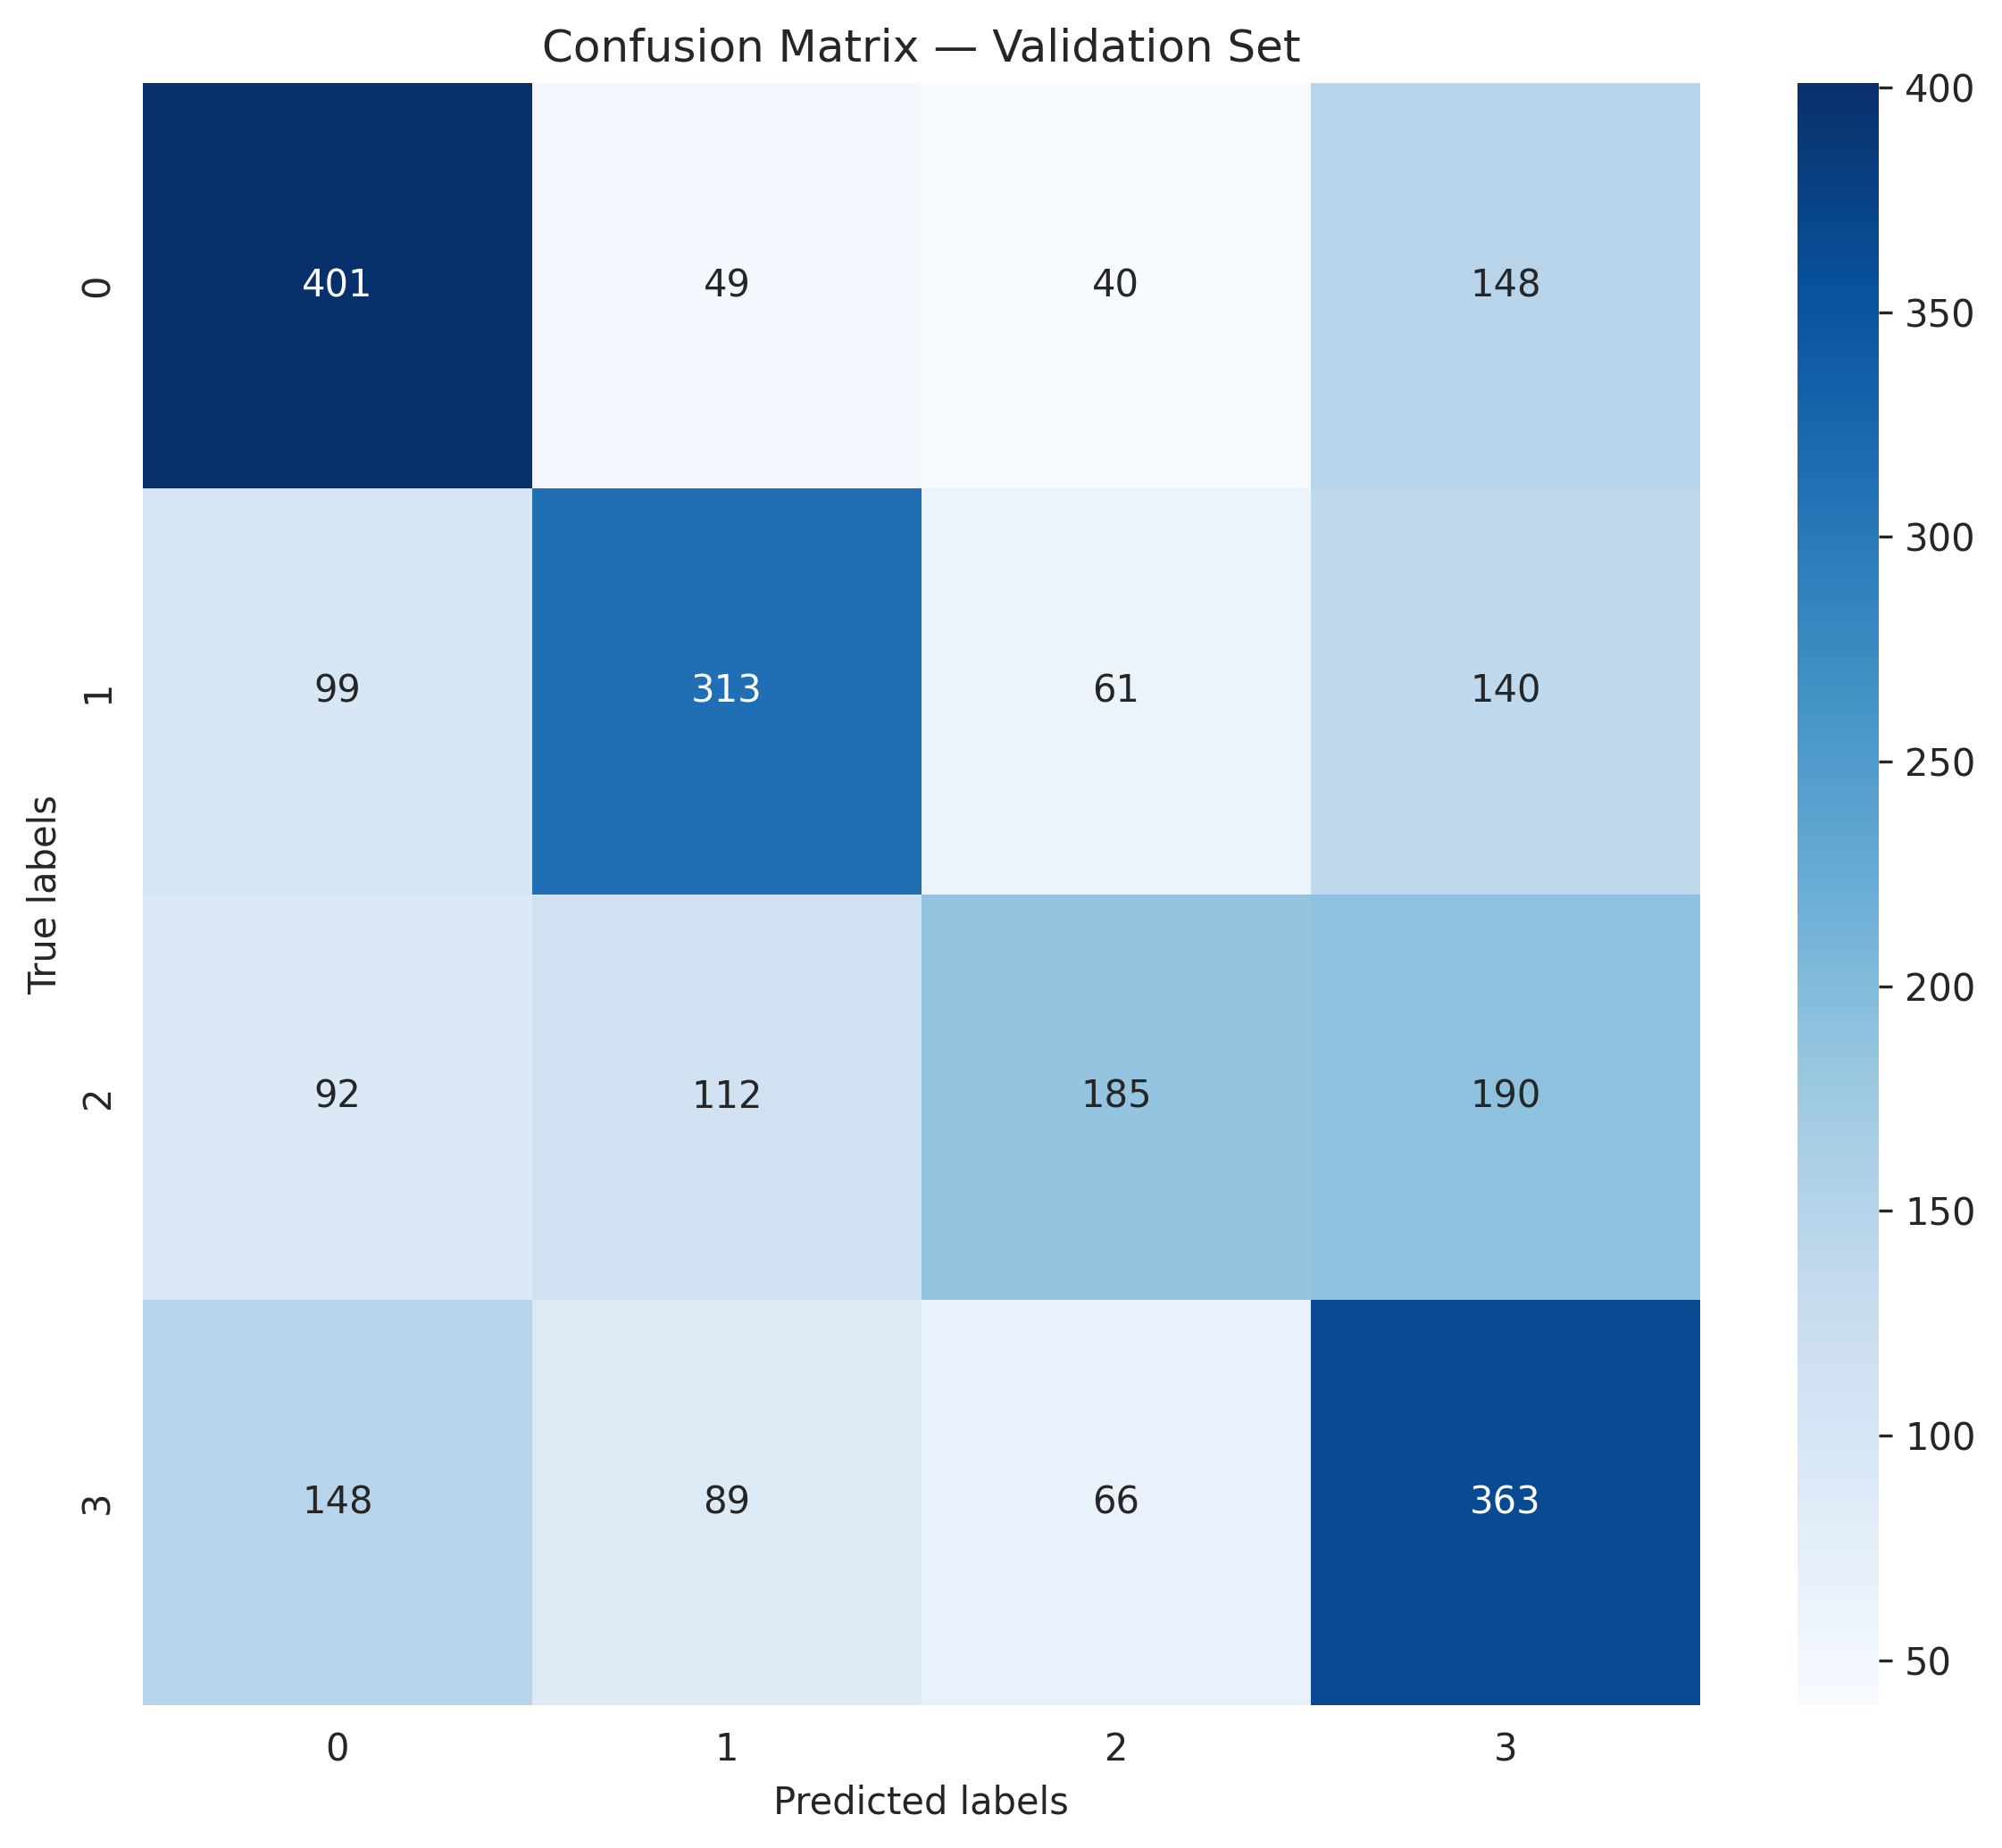

<Figure size 1920x1440 with 0 Axes>

In [31]:
# Get validation predictions
val_preds = []
val_targets = []
best_model.eval()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        logits = best_model(inputs)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        val_preds.append(preds)
        val_targets.append(targets.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation set metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(val_targets, val_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualize confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

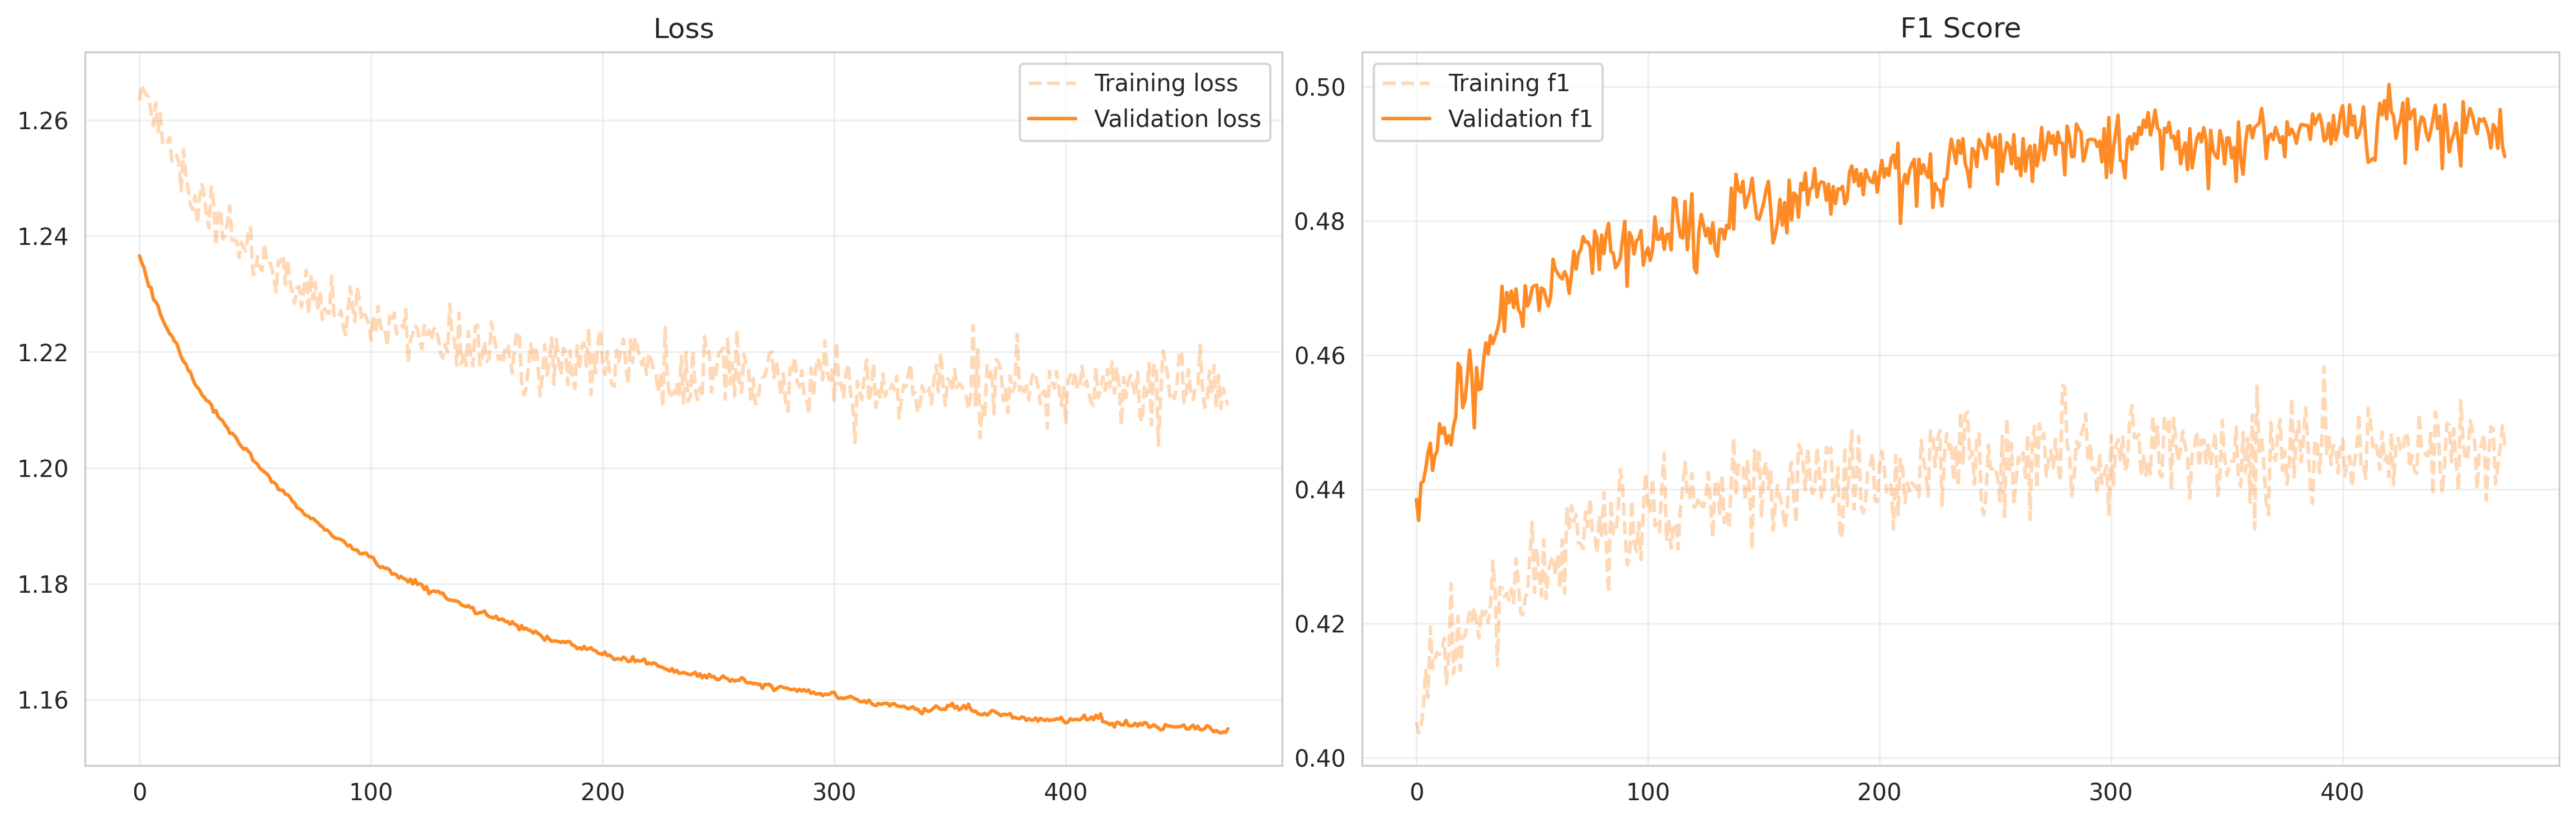

In [36]:
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
plt.show()

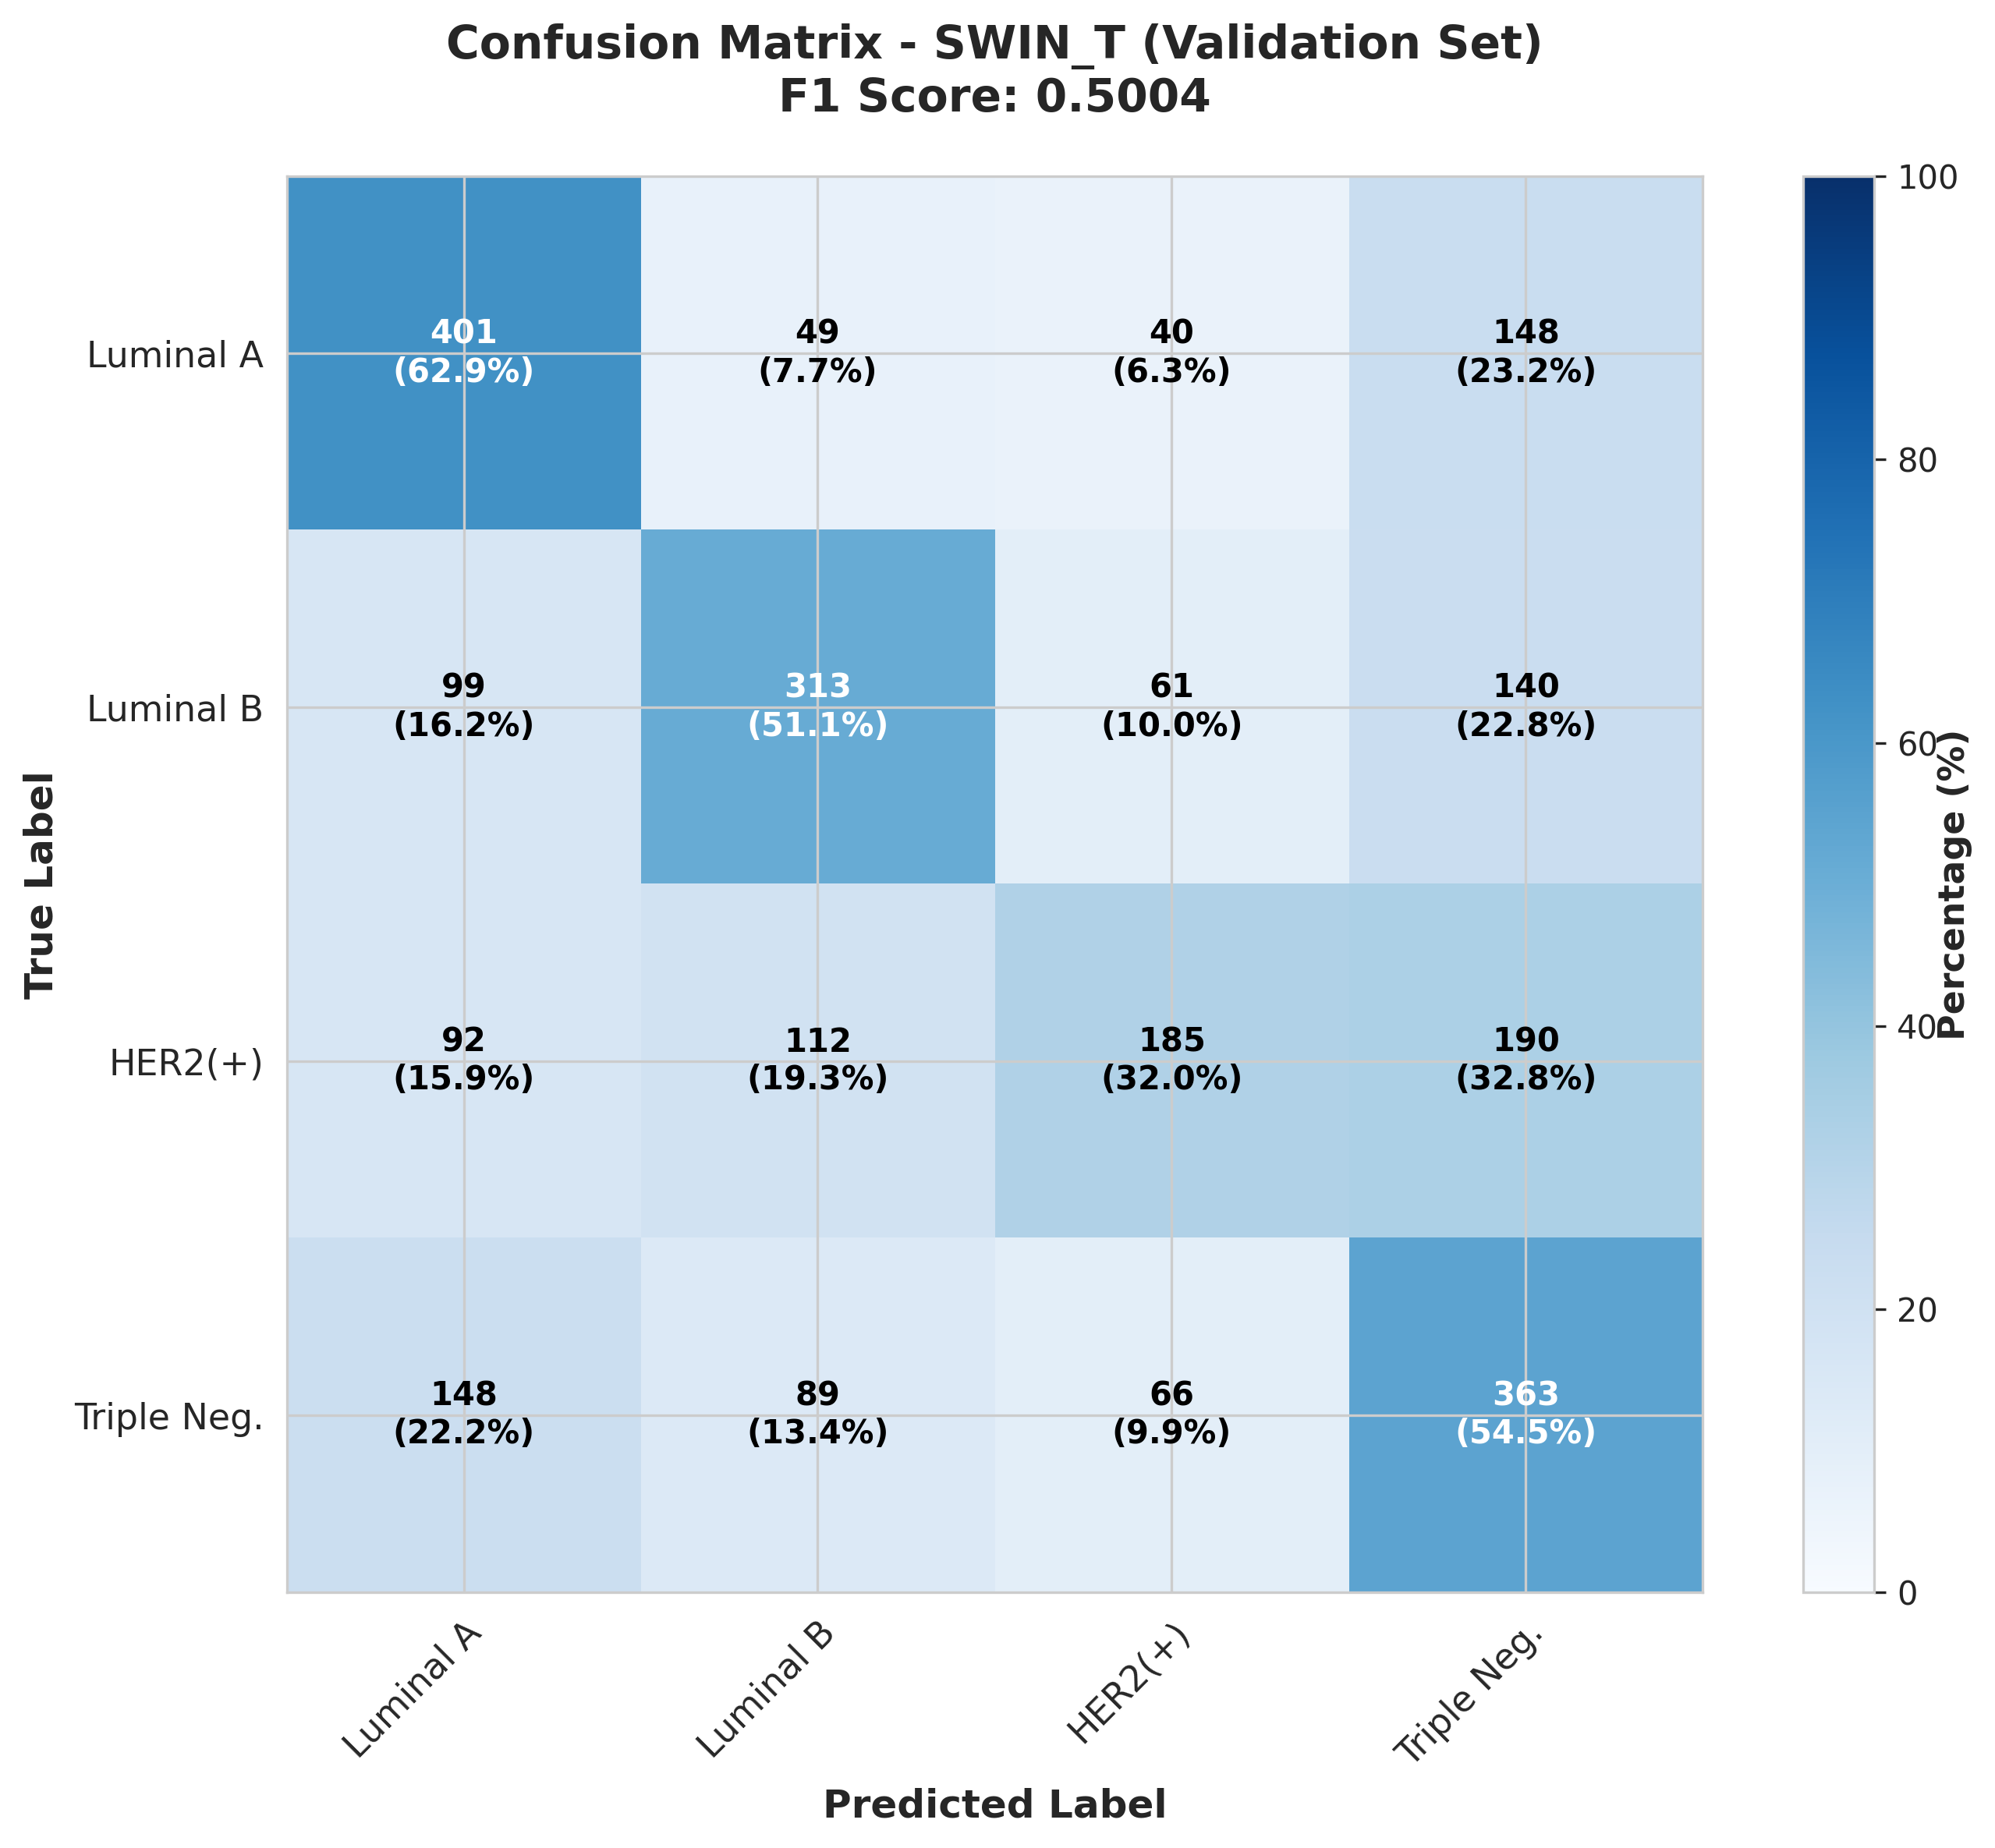

Saved: confusion_matrix.png

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Luminal A     0.5419    0.6285    0.5820       638
   Luminal B     0.5560    0.5106    0.5323       613
     HER2(+)     0.5256    0.3195    0.3974       579
 Triple Neg.     0.4316    0.5450    0.4818       666

    accuracy                         0.5056      2496
   macro avg     0.5138    0.5009    0.4984      2496
weighted avg     0.5121    0.5056    0.5002      2496



In [32]:
val_preds = []
val_targets = []
best_model.eval()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        logits = best_model(inputs)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        val_preds.append(preds)
        val_targets.append(targets.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

cm = confusion_matrix(val_targets, val_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(10, 8))

class_names = ['Luminal A', 'Luminal B', 'HER2(+)', 'Triple Neg.']
im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage (%)', rotation=90, va='bottom', fontsize=11, fontweight='bold')

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=11)
ax.set_yticklabels(class_names, fontsize=11)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        count = cm[i, j]
        percentage = cm_normalized[i, j]
        text_color = "white" if percentage > 50 else "black"
        text = ax.text(j, i, f'{count}\n({percentage:.1f}%)',
                      ha="center", va="center", color=text_color,
                      fontsize=10, fontweight='bold')

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix - {MODEL_NAME.upper()} (Validation Set)\nF1 Score: {best_f1:.4f}', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

print("Saved: confusion_matrix.png")

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(val_targets, val_preds, 
                          target_names=class_names, 
                          digits=4))

# Inference

In [33]:
patch_preds = []
patch_probs = []
best_model.eval()

print(f"Running inference on {len(test_dataset)} test patches...")
print(f"Will aggregate to {len(test_filenames)} images")

with torch.no_grad():
    for batch in test_loader:
        xb = batch.to(device)
        
        logits = best_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        
        patch_preds.append(preds)
        patch_probs.append(probs)

patch_preds = np.concatenate(patch_preds)
patch_probs = np.concatenate(patch_probs)

print(f"Got {len(patch_preds)} patch predictions")

image_preds = []
for img_idx in range(len(test_filenames)):
    patch_indices = [i for i, img_id in enumerate(test_patch_to_image) if img_id == img_idx]
    image_patch_probs = patch_probs[patch_indices]
    avg_probs = image_patch_probs.mean(axis=0)
    final_pred = avg_probs.argmax()
    image_preds.append(final_pred)

test_preds = np.array(image_preds)
print(f"Aggregated to {len(test_preds)} image predictions")

Running inference on 4294 test patches...
Will aggregate to 477 images
Got 4294 patch predictions
Aggregated to 477 image predictions


In [34]:
# Create reverse label mapping
reverse_label_map = {v: k for k, v in label_map.items()}

test_filenames = [fn.replace('mask', 'img') for fn in test_filenames]

# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': test_filenames,
    'label': [reverse_label_map[pred] for pred in test_preds]
})

# Create descriptive filename with all hyperparameters
filename_parts = [
    f"submission_{EXPERIMENT_NAME}",
    f"focus_filter",
    f"bs_{BATCH_SIZE}",
    f"lr_{LEARNING_RATE}",
    f"drop_{DROPOUT_RATE}",
    f"l1_{L1_LAMBDA}",
    f"l2_{L2_LAMBDA}",
    f"epochs_{EPOCHS}",
    f"patience_{PATIENCE}",
    f"imgsize_{IMG_SIZE[0]}x{IMG_SIZE[1]}"
]
submission_filename = "_".join(filename_parts) + ".csv"

# Save to CSV
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file created: {submission_filename}")
print(f"Total predictions: {len(submission_df)}")
print("\nFirst few predictions:")
print(submission_df.head(10))

Submission file created: submission_pretrained_swin_t_transformer_focus_filter_bs_128_lr_0.0001_drop_0.2_l1_0_l2_0.01_epochs_500_patience_50_imgsize_256x256.csv
Total predictions: 477

First few predictions:
   sample_index            label
0  img_0000.png        Luminal B
1  img_0001.png          HER2(+)
2  img_0002.png  Triple Negative
3  img_0003.png        Luminal A
4  img_0004.png          HER2(+)
5  img_0005.png  Triple Negative
6  img_0006.png        Luminal A
7  img_0007.png  Triple Negative
8  img_0008.png  Triple Negative
9  img_0009.png          HER2(+)
